<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/Amex_XGBoost_fin_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################### Installing RAPIDS on colab
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
!pip install pynvml

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#set WD
import os
os.chdir('/content/drive/MyDrive/Amex/parquet')

# XGBoost 


# Load Libraries

In [3]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

from sklearn.model_selection import KFold
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import csv, itertools

from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.inspection import permutation_importance

import itertools


print('RAPIDS version',cudf.__version__)

RAPIDS version 21.12.02


In [4]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 7

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

NUM_PARTS = 4


TRAIN_PATH = 'train.parquet'
TEST_PATH = 'test.parquet'
TARGET_PATH = 'train_labels.csv'
SAVE_PATH = '/content/drive/MyDrive/Amex/parquet/XGB final/'
SUBMISSION_FILE_PATH = '/content/drive/MyDrive/Amex/parquet/sample_submission.csv'

# Process and Feature Engineer Train Data

In [5]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None:df = pd.read_parquet(path, columns=usecols)# df = cudf.read_parquet(path, columns=usecols)
    else: df = pd.read_parquet(path) #df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    #df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    #df.S_2 = pd.to_datetime( df.S_2 )
    print('shape of data:', df.shape)
    
    return df

def to_pd(df):
  df = df.to_pandas()
  return df

def to_cu(df):
  df = cudf.from_pandas(df)
  return df

def revertnan(df):
  #df = df.to_pandas()
  df[df==-1] = np.nan 
  #df = cudf.from_pandas(df)
  return df

def fill_na(df, NAN_VALUE):
  df = df.fillna(NAN_VALUE)
  return df

def numberobs_feature(df):
  #df = df.to_pandas()
  df['number_of_observations'] = df.groupby('customer_ID')['customer_ID'].transform('count')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  #df = cudf.from_pandas(df)
  return df

def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

def get_features(df):
  all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]
  return all_cols, cat_features, num_features

def agg_functions(df, num_features, cat_features, numberobs = False#, exclnullCols, 
                  #dummy_nan_col
                  ):
  
  test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'max', 'min', 'first', 'last'])

  #test_nan_agg = df.groupby("customer_ID")[exclnullCols].agg(['last'])
  ##dummy_nan_col_agg = df.groupby("customer_ID")[dummy_nan_col].agg(['sum'])
  #df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  
  test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])


  # df = cudf.concat([test_num_agg, test_cat_agg],   #dummy_nan_col_agg, 
  #                  # test_nan_agg], 
  #                  axis=1)
  df = pd.concat([test_num_agg, test_cat_agg],   #dummy_nan_col_agg, 
  #                  # test_nan_agg], 
  #                  axis=1)

  
  df.columns = ['_'.join(x) for x in df.columns]

  if numberobs ==True:
    to_drop = ['number_of_observations_mean', 'number_of_observations_std', 'number_of_observations_max','number_of_observations_min', 'number_of_observations_first']
    df.drop(to_drop, axis = 1, inplace = True)
    df.rename(columns={'number_of_observations_last':'number_of_observations'}, inplace = True)

  del test_num_agg, test_cat_agg
  _ = gc.collect()
  print('shape after engineering', df.shape )
  return df

def add_meandev(df, num_features):
  #df = df.to_pandas()
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    #first = f'{i}_first'
    last = f'{i}_last'
    #min = f'{i}_min'
    #max = f'{i}_max' 
    mean = f'{i}_mean' 
    df[f'{i}_meandev'] = np.nan
    df.loc[(df[last] != np.nan), f'{i}_meandev'] = df[last] -df[mean]

  #df = cudf.from_pandas(df)
  return df

def dropfirst(df):
  df = df.to_pandas()
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  df = cudf.from_pandas(df)
  print('shape after engineering', df.shape )
  return df

def add_targets(df, TARGET_PATH):
  # ADD TARGETS
  targets = pd.read_csv(TARGET_PATH) #cudf.read_csv(TARGET_PATH)
  #targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  targets = targets.set_index('customer_ID')
  targets = targets.to_pandas()
  df = df.to_pandas()
  df = df.merge(targets, left_index=True, right_index=True, how='left', sort = True)
  df.target = df.target.astype('int8')
  del targets

  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.reset_index()
  return df

def add_B_29(df, B_29):
  df.drop('B_29_last', axis = 1, inplace = True)
  df = df.merge(B_29, left_index=True, right_index=True, how='left')
  del B_29
  _ =gc.collect()
  df = df.sort_index()
  return df

def add_Bratios(df):
  B_features =df.loc[:, (df.columns.str.contains('B_')) & (df.columns.str.endswith('last'))& (df.columns.str.contains('-')==False)].columns.tolist()
  Bpairs = itertools.combinations(B_features,2)
  Bpairs = list(Bpairs)
  for m,k in Bpairs:
    df[f'{m}_{k}'] = np.nan
    df.loc[(df[m] != np.nan) & (df[k] != np.nan) & (df[k] != 0),f'{m}_{k}'] = df[m]/df[k]
  del Bpairs
  _= gc.collect()
  return df

In [6]:
#all functions compact
def preprocess(PATH = TRAIN_PATH, TARGET_PATH = TARGET_PATH, train_set = True, test = None):
  if train_set == True:
    df = read_file(path = TRAIN_PATH)
  else:
    df = test
  df = to_pd(df)
  df = revertnan(df)
  df = numberobs_feature(df)
  df = to_cu(df)
  df = afterpay(df)
  all_cols, cat_features, num_features = get_features(df)
  df = agg_functions(df, num_features, cat_features, numberobs = True)
  # if train_set == True:
  #   B_29 = cudf.read_csv('/content/drive/MyDrive/Amex/parquet/XGB final/B_29_fin.csv')
  #   B_29.drop('Unnamed: 0', axis=1, inplace=True)
  #   B_29 = B_29.set_index('customer_ID')
  # else:
  #   B_29 = df['B_29_last']
  # df = add_B_29(df, B_29 = B_29)
  df = to_pd(df)
  df = add_meandev(df, num_features)
  # df = add_Bratios(df)
  df = to_cu(df)
  df = fill_na(df, NAN_VALUE)
  #df = dropfirst(df)
  #display(df)
  #display(df)
  if train_set == True:
    df = add_targets(df, TARGET_PATH)
  return df

In [7]:
train = preprocess(PATH = TRAIN_PATH)

shape of data: (5531451, 190)
shape after engineering (458913, 1180)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
train

In [8]:
#del train
gc.collect()
#train['number_of_observations']

216

In [10]:
def get_feature_list(df):
  features = df.columns[1:-1]
  print(f'There are {len(features)} features!')
  return features

In [11]:
features = get_feature_list(train)

There are 1371 features!


In [ ]:
train['number_of_observations']

In [ ]:
train[['D_131_last','D_131_meandev']]

In [65]:
gc.collect()

15403

Train XGB

In [12]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [13]:
def get_xgb_parameters():

  # XGB MODEL PARAMETERS
  # xgb_parms = { 
  #   'max_depth':4, 
  #   'learning_rate':0.05, 
  #   'subsample':0.8,
  #   'colsample_bytree':0.6, 
  #   'eval_metric':'logloss',
  #   'objective':'binary:logistic',
  #   'tree_method':'gpu_hist',
  #   'predictor':'gpu_predictor',
  #   'random_state':SEED
  # }
  xgb_parms = {
   'lambda': 0.19846538518330817, 
   'alpha': 0.11499421368543077, 
   'colsample_bytree': 1.0, 
   'subsample': 0.6, 
   'learning_rate': 0.01, 
   'max_depth': 8, 
   'min_child_weight': 56,
   'eval_metric':'logloss',
   'objective':'binary:logistic',
   'tree_method':'gpu_hist',
   'predictor':'gpu_predictor',
   'random_state':SEED  
   }
  return xgb_parms

In [14]:
xgb_parms = get_xgb_parameters()

In [15]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
train = train.to_pandas()

In [16]:
def train_model(df, SEED=SEED, SAVE_PATH =SAVE_PATH, VER=VER):
  importances = []
  oof = []
  TRAIN_SUBSAMPLE = 1.0
  gc.collect()

  skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
  for fold,(train_idx, valid_idx) in enumerate(skf.split(
            df, df.target )):
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], features, 'target')
    X_valid = df.loc[valid_idx, features]
    y_valid = df.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'{SAVE_PATH}XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df_pred = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df_pred)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df_pred = df.loc[valid_idx, ['customer_ID','target'] ].copy()
    df_pred['oof_pred'] = oof_preds
    oof.append( df_pred )
    
    del dtrain, Xy_train, dd, df_pred
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
  print('#'*25)
  oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
  acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
  print('OVERALL CV Kaggle Metric =',acc)

In [17]:
train_model(train)

#########################
### Fold 1
### Train size 367130 Valid size 91783
### Training with 100% fold data...
#########################
[0]	train-logloss:0.68639	valid-logloss:0.68643
[100]	train-logloss:0.35618	valid-logloss:0.35987
[200]	train-logloss:0.26558	valid-logloss:0.27215
[300]	train-logloss:0.23373	valid-logloss:0.24271
[400]	train-logloss:0.22046	valid-logloss:0.23154
[500]	train-logloss:0.21372	valid-logloss:0.22662
[600]	train-logloss:0.20927	valid-logloss:0.22391
[700]	train-logloss:0.20568	valid-logloss:0.22214
[800]	train-logloss:0.20287	valid-logloss:0.22090
[900]	train-logloss:0.20033	valid-logloss:0.21997
[1000]	train-logloss:0.19817	valid-logloss:0.21924
[1100]	train-logloss:0.19603	valid-logloss:0.21866
[1200]	train-logloss:0.19402	valid-logloss:0.21818
[1300]	train-logloss:0.19219	valid-logloss:0.21781
[1400]	train-logloss:0.19051	valid-logloss:0.21746
[1500]	train-logloss:0.18882	valid-logloss:0.21718
[1600]	train-logloss:0.18720	valid-logloss:0.21694
[1700]	



```
base = 0.791536
ohne na Behandlung = 0.790870
na fill nach agg = 0.7916640
revertnan und na_fill nach agg = 0.791823
mit number of obs (und na_fill nach agg) = 0.79223834
so mit growth feature = 0.79185923 ??
mit abschange = 0.7917617 ??
mit abschange nicht skaliert = 0.791859 ?
number of obs in buckets (größer 10) + abschange = 0.7915386 ?
mit number_of_obs und min-max = 0.792181
mit number of obs (und na_fill nach agg)fillna vor meandev + mean deviation = 0.792464
mit number of obs (und na_fill nach agg) fillna nach meandev + mean deviation = 0.79237036 (=VER 1, 0.794 public lb)
s.o. + after pay features = 0.79310
VER 3: s.o. mit getunten Hyperparametern = 0.794355 (V3, 0.796 public lb)
s.o. mit B_29 = 0.794610 (v5, 0.796 public lb)
so ohne B_29 mit 1:100 Bratios = 0.7951046
so mit allen Bratios = 0.7952144 (0.795 lb)
VER 3 + first: 0.794577



In [48]:
gc.collect()

279

In [20]:
del train

Prepare Testdata

In [49]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [50]:
def get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS):
  print(f'Reading test data...')
  test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
  customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
  rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')
  return rows,num_cust,customers

In [51]:
def infer_test(rows,num_cust,customers, VER=VER,features=features, SUBMISSION_FILE_PATH = SUBMISSION_FILE_PATH ):
  # INFER TEST DATA IN PARTS
  skip_rows = 0
  skip_cust = 0
  test_preds = []

  for k in range(NUM_PARTS):
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = preprocess(train_set = False, test = test) 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    test = test[['P_2_mean']] # reduce memory
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'{SAVE_PATH}XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()

  test_preds = np.concatenate(test_preds)
  test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
  sub = cudf.read_csv(SUBMISSION_FILE_PATH)[['customer_ID']]
  sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  sub = sub.set_index('customer_ID_hash')
  sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
  sub = sub.reset_index(drop=True)

  sub.to_csv(f'{SAVE_PATH}submission_xgb_v{VER}.csv',index=False)
  print('Submission file shape is', sub.shape )
  sub.head()

In [52]:
def test_pred():
  rows,num_cust, customers = get_rowsnumcust(TEST_PATH, NUM_PARTS=NUM_PARTS)
  infer_test(rows=rows,num_cust=num_cust, customers=customers)


In [53]:
test_pred()

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]

Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1180)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1180)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1180)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1180)
Submission file shape is (924621, 2)


In [36]:
gc.collect()

88

### ENDE

In [ ]:
#train test split
train_df, test_df = train_test_split(train, test_size=0.25, stratify=train['target'])

In [ ]:
!pip install optuna
import optuna

In [ ]:
# optuna

def objective(trial, IterLoadForDMatrix, train_df, test_df, features):
    
    param = {
        'booster':'gbtree',
        'tree_method':'gpu_hist', 
        "objective": "binary:logistic",
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_float(
            'colsample_bytree', 0.5,1,step=0.1
        ),
        'subsample': trial.suggest_float(
            'subsample', 0.5,1,step=0.1
        ),
        'learning_rate': trial.suggest_float(
            'learning_rate', 0.01,0.05,step=0.005
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 4,9,1
        ),
        'random_state': 99,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1,256,1
        ),
    }
    
    

    
    
    
    
    oof = []
    gc.collect()
    

        
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train_df, features, 'target')
        
    X_valid = test_df.loc[:, features]
    y_valid = test_df.loc[:, 'target']
      
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
      
        

        
        # TRAIN MODEL FOLD K
    model = xgb.train(param, 
                  dtrain=dtrain,
                  evals=[(dtrain,'train'),(dvalid,'valid')],
                  num_boost_round=9999,
                  early_stopping_rounds=100,
                  verbose_eval=300
                  ) 
      
        
        # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
        #acc = amex_metric_mod(y_valid.values, oof_preds)
    
    
        # SAVE OOF
    df = test_df.loc[:, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append(df)

              


    del dtrain, Xy_train, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    

    oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
    metric = amex_metric_mod(oof.target.values, oof.oof_pred.values)
        
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(
        trial, IterLoadForDMatrix, train_df, test_df, features), n_trials= 100) 

[I 2022-08-01 22:22:24,836] A new study created in memory with name: no-name-4863041f-6924-4558-9691-d5053d28eb41


[22:22:39] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66094	valid-logloss:0.66104
[300]	train-logloss:0.20971	valid-logloss:0.21971
[600]	train-logloss:0.19954	valid-logloss:0.21720
[900]	train-logloss:0.19182	valid-logloss:0.21666
[1200]	train-logloss:0.18473	valid-logloss:0.21647
[1473]	train-logloss:0.17880	valid-logloss:0.21644


[I 2022-08-01 22:24:54,137] Trial 0 finished with value: 0.7916683328681577 and parameters: {'lambda': 0.027517637245856656, 'alpha': 0.01961380463369411, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 203}. Best is trial 0 with value: 0.7916683328681577.


[22:25:07] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66995	valid-logloss:0.67011
[300]	train-logloss:0.20145	valid-logloss:0.21984
[600]	train-logloss:0.18783	valid-logloss:0.21703
[900]	train-logloss:0.17787	valid-logloss:0.21647
[1200]	train-logloss:0.16889	valid-logloss:0.21624
[1289]	train-logloss:0.16647	valid-logloss:0.21631


[I 2022-08-01 22:28:00,043] Trial 1 finished with value: 0.7930665800408387 and parameters: {'lambda': 0.040050278461401155, 'alpha': 0.7429338562118817, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.035, 'max_depth': 9, 'min_child_weight': 188}. Best is trial 1 with value: 0.7930665800408387.


[22:28:13] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66446	valid-logloss:0.66453
[300]	train-logloss:0.21473	valid-logloss:0.22157
[600]	train-logloss:0.20580	valid-logloss:0.21782
[900]	train-logloss:0.20007	valid-logloss:0.21680
[1200]	train-logloss:0.19490	valid-logloss:0.21641
[1500]	train-logloss:0.19003	valid-logloss:0.21620
[1633]	train-logloss:0.18801	valid-logloss:0.21618


[I 2022-08-01 22:30:31,948] Trial 2 finished with value: 0.7931976046011235 and parameters: {'lambda': 2.0759991262490445, 'alpha': 0.14516699713364045, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.045000000000000005, 'max_depth': 5, 'min_child_weight': 202}. Best is trial 2 with value: 0.7931976046011235.


[22:30:45] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66326	valid-logloss:0.66361
[300]	train-logloss:0.16720	valid-logloss:0.21865
[506]	train-logloss:0.14189	valid-logloss:0.21829


[I 2022-08-01 22:32:29,135] Trial 3 finished with value: 0.7900436896004479 and parameters: {'lambda': 8.170956320923727, 'alpha': 0.014507350578292432, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.045000000000000005, 'max_depth': 9, 'min_child_weight': 6}. Best is trial 2 with value: 0.7931976046011235.


[22:32:42] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68648	valid-logloss:0.68651
[300]	train-logloss:0.23615	valid-logloss:0.24480
[600]	train-logloss:0.21020	valid-logloss:0.22506
[900]	train-logloss:0.19972	valid-logloss:0.22073
[1200]	train-logloss:0.19233	valid-logloss:0.21878
[1500]	train-logloss:0.18621	valid-logloss:0.21765
[1800]	train-logloss:0.18087	valid-logloss:0.21695
[2100]	train-logloss:0.17594	valid-logloss:0.21646
[2400]	train-logloss:0.17165	valid-logloss:0.21613
[2700]	train-logloss:0.16752	valid-logloss:0.21592
[3000]	train-logloss:0.16340	valid-logloss:0.21575
[3300]	train-logloss:0.15965	valid-logloss:0.21562
[3600]	train-logloss:0.15614	valid-logloss:0.21551
[3900]	train-logloss:0.15251	valid

[I 2022-08-01 22:40:37,587] Trial 4 finished with value: 0.7937071894431 and parameters: {'lambda': 4.813457241008532, 'alpha': 0.06200467596226268, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 4 with value: 0.7937071894431.


[22:40:51] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68323	valid-logloss:0.68329
[300]	train-logloss:0.22713	valid-logloss:0.23249
[600]	train-logloss:0.21397	valid-logloss:0.22247
[900]	train-logloss:0.20803	valid-logloss:0.21939
[1200]	train-logloss:0.20374	valid-logloss:0.21799
[1500]	train-logloss:0.20013	valid-logloss:0.21722
[1800]	train-logloss:0.19686	valid-logloss:0.21672
[2100]	train-logloss:0.19375	valid-logloss:0.21646
[2400]	train-logloss:0.19082	valid-logloss:0.21623
[2700]	train-logloss:0.18792	valid-logloss:0.21608
[3000]	train-logloss:0.18528	valid-logloss:0.21594
[3300]	train-logloss:0.18241	valid-logloss:0.21584
[3600]	train-logloss:0.17971	valid-logloss:0.21576
[3791]	train-logloss:0.17806	valid

[I 2022-08-01 22:48:07,302] Trial 5 finished with value: 0.7939719750110332 and parameters: {'lambda': 0.013247742475008572, 'alpha': 0.018509188940509118, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 202}. Best is trial 5 with value: 0.7939719750110332.


[22:48:20] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66731	valid-logloss:0.66742
[300]	train-logloss:0.21142	valid-logloss:0.22137
[600]	train-logloss:0.20140	valid-logloss:0.21790
[900]	train-logloss:0.19495	valid-logloss:0.21696
[1200]	train-logloss:0.18889	valid-logloss:0.21648
[1500]	train-logloss:0.18367	valid-logloss:0.21633
[1548]	train-logloss:0.18277	valid-logloss:0.21633


[I 2022-08-01 22:50:52,578] Trial 6 finished with value: 0.7920212390719875 and parameters: {'lambda': 0.6448641688825628, 'alpha': 2.911844147220834, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 241}. Best is trial 5 with value: 0.7939719750110332.


[22:51:06] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68632	valid-logloss:0.68640
[300]	train-logloss:0.22494	valid-logloss:0.24100
[600]	train-logloss:0.19743	valid-logloss:0.22274
[900]	train-logloss:0.18636	valid-logloss:0.21929
[1200]	train-logloss:0.17830	valid-logloss:0.21791
[1500]	train-logloss:0.17166	valid-logloss:0.21718
[1800]	train-logloss:0.16609	valid-logloss:0.21673
[2100]	train-logloss:0.16112	valid-logloss:0.21649
[2400]	train-logloss:0.15649	valid-logloss:0.21629
[2700]	train-logloss:0.15222	valid-logloss:0.21619
[3000]	train-logloss:0.14803	valid-logloss:0.21613
[3125]	train-logloss:0.14611	valid-logloss:0.21615


[I 2022-08-01 23:00:54,485] Trial 7 finished with value: 0.7942657620268125 and parameters: {'lambda': 0.6861938017065641, 'alpha': 0.005103680677939387, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 47}. Best is trial 7 with value: 0.7942657620268125.


[23:01:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68313	valid-logloss:0.68317
[300]	train-logloss:0.21663	valid-logloss:0.22971
[600]	train-logloss:0.19622	valid-logloss:0.22058
[900]	train-logloss:0.18398	valid-logloss:0.21811
[1200]	train-logloss:0.17420	valid-logloss:0.21693
[1500]	train-logloss:0.16575	valid-logloss:0.21633
[1800]	train-logloss:0.15824	valid-logloss:0.21600
[2100]	train-logloss:0.15099	valid-logloss:0.21581
[2400]	train-logloss:0.14435	valid-logloss:0.21575
[2508]	train-logloss:0.14207	valid-logloss:0.21576


[I 2022-08-01 23:06:23,337] Trial 8 finished with value: 0.7936360580659519 and parameters: {'lambda': 1.1391073270287757, 'alpha': 0.0026113254220730903, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 5}. Best is trial 7 with value: 0.7942657620268125.


[23:06:36] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68329	valid-logloss:0.68333
[300]	train-logloss:0.22750	valid-logloss:0.23337
[600]	train-logloss:0.21264	valid-logloss:0.22277
[900]	train-logloss:0.20587	valid-logloss:0.21959
[1200]	train-logloss:0.20100	valid-logloss:0.21803
[1500]	train-logloss:0.19674	valid-logloss:0.21715
[1800]	train-logloss:0.19297	valid-logloss:0.21660
[2100]	train-logloss:0.18941	valid-logloss:0.21624
[2400]	train-logloss:0.18599	valid-logloss:0.21594
[2700]	train-logloss:0.18262	valid-logloss:0.21572
[3000]	train-logloss:0.17944	valid-logloss:0.21557
[3300]	train-logloss:0.17634	valid-logloss:0.21547
[3600]	train-logloss:0.17327	valid-logloss:0.21536
[3725]	train-logloss:0.17206	valid

[I 2022-08-01 23:12:54,851] Trial 9 finished with value: 0.7938780541152959 and parameters: {'lambda': 0.005881926790367044, 'alpha': 3.761020527165246, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 82}. Best is trial 7 with value: 0.7942657620268125.


[23:13:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67732	valid-logloss:0.67737
[300]	train-logloss:0.22613	valid-logloss:0.22996
[600]	train-logloss:0.21577	valid-logloss:0.22234
[900]	train-logloss:0.21069	valid-logloss:0.21965
[1200]	train-logloss:0.20699	valid-logloss:0.21830
[1500]	train-logloss:0.20383	valid-logloss:0.21749
[1800]	train-logloss:0.20112	valid-logloss:0.21699
[2100]	train-logloss:0.19856	valid-logloss:0.21667
[2400]	train-logloss:0.19605	valid-logloss:0.21641
[2700]	train-logloss:0.19366	valid-logloss:0.21623
[3000]	train-logloss:0.19143	valid-logloss:0.21611
[3300]	train-logloss:0.18930	valid-logloss:0.21597
[3600]	train-logloss:0.18724	valid-logloss:0.21590
[3713]	train-logloss:0.18647	valid

[I 2022-08-01 23:17:46,183] Trial 10 finished with value: 0.7932816796099602 and parameters: {'lambda': 0.0010261535763642071, 'alpha': 0.0010005833709620631, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.025, 'max_depth': 4, 'min_child_weight': 88}. Best is trial 7 with value: 0.7942657620268125.


[23:17:59] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67658	valid-logloss:0.67665
[300]	train-logloss:0.21295	valid-logloss:0.22298
[600]	train-logloss:0.20147	valid-logloss:0.21835
[900]	train-logloss:0.19356	valid-logloss:0.21712
[1200]	train-logloss:0.18664	valid-logloss:0.21659
[1500]	train-logloss:0.18019	valid-logloss:0.21622
[1800]	train-logloss:0.17400	valid-logloss:0.21612
[1876]	train-logloss:0.17236	valid-logloss:0.21618


[I 2022-08-01 23:22:15,980] Trial 11 finished with value: 0.793795661927035 and parameters: {'lambda': 0.18649235296097572, 'alpha': 0.006314146500178859, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 136}. Best is trial 7 with value: 0.7942657620268125.


[23:22:29] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68651
[300]	train-logloss:0.23846	valid-logloss:0.24453
[600]	train-logloss:0.21569	valid-logloss:0.22515
[900]	train-logloss:0.20844	valid-logloss:0.22088
[1200]	train-logloss:0.20357	valid-logloss:0.21887
[1500]	train-logloss:0.19959	valid-logloss:0.21776
[1800]	train-logloss:0.19623	valid-logloss:0.21712
[2100]	train-logloss:0.19307	valid-logloss:0.21668
[2400]	train-logloss:0.19008	valid-logloss:0.21631
[2700]	train-logloss:0.18716	valid-logloss:0.21609
[3000]	train-logloss:0.18442	valid-logloss:0.21590
[3300]	train-logloss:0.18162	valid-logloss:0.21573
[3600]	train-logloss:0.17888	valid-logloss:0.21562
[3900]	train-logloss:0.17628	valid

[I 2022-08-01 23:32:38,537] Trial 12 finished with value: 0.7943557866488324 and parameters: {'lambda': 0.15418153458312894, 'alpha': 0.06813177040891014, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 139}. Best is trial 12 with value: 0.7943557866488324.


[23:32:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68650
[300]	train-logloss:0.23757	valid-logloss:0.24412
[600]	train-logloss:0.21456	valid-logloss:0.22481
[900]	train-logloss:0.20713	valid-logloss:0.22068
[1200]	train-logloss:0.20201	valid-logloss:0.21867
[1500]	train-logloss:0.19786	valid-logloss:0.21761
[1800]	train-logloss:0.19420	valid-logloss:0.21697
[2100]	train-logloss:0.19086	valid-logloss:0.21654
[2400]	train-logloss:0.18768	valid-logloss:0.21622
[2700]	train-logloss:0.18448	valid-logloss:0.21596
[3000]	train-logloss:0.18155	valid-logloss:0.21582
[3300]	train-logloss:0.17864	valid-logloss:0.21565
[3600]	train-logloss:0.17577	valid-logloss:0.21552
[3900]	train-logloss:0.17301	valid

[I 2022-08-01 23:44:11,902] Trial 13 finished with value: 0.7956672220772174 and parameters: {'lambda': 0.2185304199028929, 'alpha': 0.20239986432467147, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 118}. Best is trial 13 with value: 0.7956672220772174.


[23:44:25] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67656	valid-logloss:0.67664
[300]	train-logloss:0.21208	valid-logloss:0.22287
[600]	train-logloss:0.20022	valid-logloss:0.21800
[900]	train-logloss:0.19232	valid-logloss:0.21679
[1200]	train-logloss:0.18530	valid-logloss:0.21631
[1500]	train-logloss:0.17887	valid-logloss:0.21608
[1800]	train-logloss:0.17253	valid-logloss:0.21590
[1979]	train-logloss:0.16889	valid-logloss:0.21588


[I 2022-08-01 23:48:43,755] Trial 14 finished with value: 0.7929174702629913 and parameters: {'lambda': 0.16066794154691608, 'alpha': 0.2546056323058142, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 140}. Best is trial 13 with value: 0.7956672220772174.


[23:48:57] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67980	valid-logloss:0.67990
[300]	train-logloss:0.21371	valid-logloss:0.22471
[600]	train-logloss:0.20089	valid-logloss:0.21876
[900]	train-logloss:0.19265	valid-logloss:0.21708
[1200]	train-logloss:0.18561	valid-logloss:0.21635
[1500]	train-logloss:0.17925	valid-logloss:0.21594
[1800]	train-logloss:0.17320	valid-logloss:0.21569
[2100]	train-logloss:0.16750	valid-logloss:0.21556
[2295]	train-logloss:0.16388	valid-logloss:0.21557


[I 2022-08-01 23:54:17,888] Trial 15 finished with value: 0.7931771491358758 and parameters: {'lambda': 0.0990298179165763, 'alpha': 0.47795153814583785, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 8, 'min_child_weight': 103}. Best is trial 13 with value: 0.7956672220772174.


[23:54:31] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68647	valid-logloss:0.68651
[300]	train-logloss:0.23934	valid-logloss:0.24498
[600]	train-logloss:0.21668	valid-logloss:0.22543
[900]	train-logloss:0.20957	valid-logloss:0.22111
[1200]	train-logloss:0.20482	valid-logloss:0.21904
[1500]	train-logloss:0.20098	valid-logloss:0.21793
[1800]	train-logloss:0.19770	valid-logloss:0.21725
[2100]	train-logloss:0.19471	valid-logloss:0.21680
[2400]	train-logloss:0.19189	valid-logloss:0.21647
[2700]	train-logloss:0.18909	valid-logloss:0.21625
[3000]	train-logloss:0.18657	valid-logloss:0.21608
[3300]	train-logloss:0.18388	valid-logloss:0.21590
[3600]	train-logloss:0.18127	valid-logloss:0.21579
[3900]	train-logloss:0.17880	valid

[I 2022-08-02 00:06:54,512] Trial 16 finished with value: 0.7938687365856112 and parameters: {'lambda': 0.2941005315963989, 'alpha': 0.0590768841258766, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 159}. Best is trial 13 with value: 0.7956672220772174.


[00:07:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67329	valid-logloss:0.67340
[300]	train-logloss:0.20877	valid-logloss:0.22113
[600]	train-logloss:0.19604	valid-logloss:0.21754
[900]	train-logloss:0.18638	valid-logloss:0.21666
[1110]	train-logloss:0.18025	valid-logloss:0.21649


[I 2022-08-02 00:09:40,284] Trial 17 finished with value: 0.7936164456212695 and parameters: {'lambda': 0.04359420871351157, 'alpha': 0.9269659641904361, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 110}. Best is trial 13 with value: 0.7956672220772174.


[00:09:53] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67960	valid-logloss:0.67973
[300]	train-logloss:0.20288	valid-logloss:0.22280
[600]	train-logloss:0.18596	valid-logloss:0.21774
[900]	train-logloss:0.17435	valid-logloss:0.21640
[1200]	train-logloss:0.16432	valid-logloss:0.21588
[1500]	train-logloss:0.15514	valid-logloss:0.21573
[1513]	train-logloss:0.15474	valid-logloss:0.21572


[I 2022-08-02 00:14:22,545] Trial 18 finished with value: 0.7945551115881642 and parameters: {'lambda': 0.00316672716769826, 'alpha': 0.08813030286065213, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 55}. Best is trial 13 with value: 0.7956672220772174.


[00:14:36] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67961	valid-logloss:0.67975
[300]	train-logloss:0.20377	valid-logloss:0.22276
[600]	train-logloss:0.18744	valid-logloss:0.21775
[900]	train-logloss:0.17596	valid-logloss:0.21646
[1200]	train-logloss:0.16654	valid-logloss:0.21593
[1500]	train-logloss:0.15731	valid-logloss:0.21569
[1800]	train-logloss:0.14934	valid-logloss:0.21560
[1804]	train-logloss:0.14918	valid-logloss:0.21561


[I 2022-08-02 00:19:27,023] Trial 19 finished with value: 0.7935487126787917 and parameters: {'lambda': 0.003154701655433623, 'alpha': 0.20384805130640907, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 58}. Best is trial 13 with value: 0.7956672220772174.


[00:19:40] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67959	valid-logloss:0.67973
[300]	train-logloss:0.20028	valid-logloss:0.22277
[600]	train-logloss:0.18139	valid-logloss:0.21775
[900]	train-logloss:0.16840	valid-logloss:0.21648
[1200]	train-logloss:0.15744	valid-logloss:0.21596
[1500]	train-logloss:0.14725	valid-logloss:0.21577
[1797]	train-logloss:0.13797	valid-logloss:0.21573


[I 2022-08-02 00:25:20,064] Trial 20 finished with value: 0.7944133517344045 and parameters: {'lambda': 0.0028514035268136033, 'alpha': 1.6055702931899118, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 46}. Best is trial 13 with value: 0.7956672220772174.


[00:25:34] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67968	valid-logloss:0.67981
[300]	train-logloss:0.20372	valid-logloss:0.22357
[600]	train-logloss:0.18452	valid-logloss:0.21810
[900]	train-logloss:0.17025	valid-logloss:0.21660
[1200]	train-logloss:0.15793	valid-logloss:0.21609
[1500]	train-logloss:0.14626	valid-logloss:0.21595
[1516]	train-logloss:0.14567	valid-logloss:0.21592


[I 2022-08-02 00:31:05,392] Trial 21 finished with value: 0.7931303954450128 and parameters: {'lambda': 0.0011749652675451798, 'alpha': 8.01634330752871, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 43}. Best is trial 13 with value: 0.7956672220772174.


[00:31:19] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67300	valid-logloss:0.67318
[300]	train-logloss:0.19557	valid-logloss:0.21977
[600]	train-logloss:0.17673	valid-logloss:0.21688
[900]	train-logloss:0.16161	valid-logloss:0.21627
[1125]	train-logloss:0.15138	valid-logloss:0.21623


[I 2022-08-02 00:34:48,449] Trial 22 finished with value: 0.7941455715028345 and parameters: {'lambda': 0.004301504258950281, 'alpha': 1.569688056786435, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 9, 'min_child_weight': 63}. Best is trial 13 with value: 0.7956672220772174.


[00:35:02] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68292	valid-logloss:0.68305
[300]	train-logloss:0.20397	valid-logloss:0.22661
[600]	train-logloss:0.18267	valid-logloss:0.21893
[900]	train-logloss:0.17003	valid-logloss:0.21702
[1200]	train-logloss:0.16009	valid-logloss:0.21622
[1500]	train-logloss:0.15151	valid-logloss:0.21589
[1800]	train-logloss:0.14346	valid-logloss:0.21572
[2100]	train-logloss:0.13605	valid-logloss:0.21563
[2358]	train-logloss:0.12994	valid-logloss:0.21560


[I 2022-08-02 00:42:20,555] Trial 23 finished with value: 0.7949449700647302 and parameters: {'lambda': 0.00998402275676324, 'alpha': 0.35825179262028417, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 33}. Best is trial 13 with value: 0.7956672220772174.


[00:42:34] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68302	valid-logloss:0.68313
[300]	train-logloss:0.21163	valid-logloss:0.22813
[600]	train-logloss:0.19212	valid-logloss:0.21966
[900]	train-logloss:0.18091	valid-logloss:0.21751
[1200]	train-logloss:0.17205	valid-logloss:0.21653
[1500]	train-logloss:0.16446	valid-logloss:0.21613
[1800]	train-logloss:0.15754	valid-logloss:0.21584
[2100]	train-logloss:0.15122	valid-logloss:0.21566
[2400]	train-logloss:0.14486	valid-logloss:0.21564


[I 2022-08-02 00:48:50,721] Trial 24 finished with value: 0.795338242294328 and parameters: {'lambda': 0.014116529264441124, 'alpha': 0.3498631754667191, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 32}. Best is trial 13 with value: 0.7956672220772174.


[00:49:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68313	valid-logloss:0.68320
[300]	train-logloss:0.21868	valid-logloss:0.23019
[600]	train-logloss:0.20017	valid-logloss:0.22079
[900]	train-logloss:0.19007	valid-logloss:0.21823
[1200]	train-logloss:0.18242	valid-logloss:0.21708
[1500]	train-logloss:0.17575	valid-logloss:0.21650
[1800]	train-logloss:0.16970	valid-logloss:0.21618
[2100]	train-logloss:0.16426	valid-logloss:0.21601
[2400]	train-logloss:0.15888	valid-logloss:0.21588
[2700]	train-logloss:0.15396	valid-logloss:0.21578
[2983]	train-logloss:0.14939	valid-logloss:0.21575


[I 2022-08-02 00:55:28,579] Trial 25 finished with value: 0.794634498472057 and parameters: {'lambda': 0.013395956185006925, 'alpha': 0.30321193917272904, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 27}. Best is trial 13 with value: 0.7956672220772174.


[00:55:42] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68307	valid-logloss:0.68315
[300]	train-logloss:0.21610	valid-logloss:0.22887
[600]	train-logloss:0.19982	valid-logloss:0.22022
[900]	train-logloss:0.19106	valid-logloss:0.21781
[1200]	train-logloss:0.18418	valid-logloss:0.21675
[1500]	train-logloss:0.17828	valid-logloss:0.21621
[1800]	train-logloss:0.17285	valid-logloss:0.21588
[2100]	train-logloss:0.16782	valid-logloss:0.21567
[2400]	train-logloss:0.16289	valid-logloss:0.21557
[2700]	train-logloss:0.15823	valid-logloss:0.21546
[2900]	train-logloss:0.15532	valid-logloss:0.21544


[I 2022-08-02 01:02:14,227] Trial 26 finished with value: 0.7944622028378758 and parameters: {'lambda': 0.012214579453032634, 'alpha': 0.4257502463675535, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 77}. Best is trial 13 with value: 0.7956672220772174.


[01:02:27] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68645	valid-logloss:0.68650
[300]	train-logloss:0.23609	valid-logloss:0.24457
[600]	train-logloss:0.21030	valid-logloss:0.22496
[900]	train-logloss:0.20018	valid-logloss:0.22065
[1200]	train-logloss:0.19319	valid-logloss:0.21872
[1500]	train-logloss:0.18745	valid-logloss:0.21768
[1800]	train-logloss:0.18248	valid-logloss:0.21700
[2100]	train-logloss:0.17804	valid-logloss:0.21654
[2400]	train-logloss:0.17394	valid-logloss:0.21624
[2700]	train-logloss:0.17009	valid-logloss:0.21603
[3000]	train-logloss:0.16636	valid-logloss:0.21584
[3300]	train-logloss:0.16278	valid-logloss:0.21571
[3600]	train-logloss:0.15944	valid-logloss:0.21560
[3900]	train-logloss:0.15609	valid

[I 2022-08-02 01:13:22,936] Trial 27 finished with value: 0.7943654397347306 and parameters: {'lambda': 0.059469576682489735, 'alpha': 0.04257187692969981, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 27}. Best is trial 13 with value: 0.7956672220772174.


[01:13:36] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68309	valid-logloss:0.68316
[300]	train-logloss:0.21727	valid-logloss:0.22932
[600]	train-logloss:0.20169	valid-logloss:0.22060
[900]	train-logloss:0.19384	valid-logloss:0.21823
[1200]	train-logloss:0.18763	valid-logloss:0.21716
[1500]	train-logloss:0.18228	valid-logloss:0.21659
[1800]	train-logloss:0.17758	valid-logloss:0.21625
[2100]	train-logloss:0.17308	valid-logloss:0.21600
[2400]	train-logloss:0.16882	valid-logloss:0.21591
[2700]	train-logloss:0.16496	valid-logloss:0.21585
[3000]	train-logloss:0.16067	valid-logloss:0.21577
[3065]	train-logloss:0.15984	valid-logloss:0.21578


[I 2022-08-02 01:20:13,044] Trial 28 finished with value: 0.7931756216928036 and parameters: {'lambda': 0.022456900649147696, 'alpha': 0.7769455485865373, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 105}. Best is trial 13 with value: 0.7956672220772174.


[01:20:27] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67703	valid-logloss:0.67708
[300]	train-logloss:0.22188	valid-logloss:0.22728
[600]	train-logloss:0.21180	valid-logloss:0.22069
[900]	train-logloss:0.20657	valid-logloss:0.21856
[1200]	train-logloss:0.20245	valid-logloss:0.21746
[1500]	train-logloss:0.19893	valid-logloss:0.21688
[1800]	train-logloss:0.19568	valid-logloss:0.21650
[2100]	train-logloss:0.19252	valid-logloss:0.21624
[2400]	train-logloss:0.18943	valid-logloss:0.21607
[2700]	train-logloss:0.18650	valid-logloss:0.21602
[3000]	train-logloss:0.18375	valid-logloss:0.21595
[3134]	train-logloss:0.18244	valid-logloss:0.21594


[I 2022-08-02 01:24:56,356] Trial 29 finished with value: 0.7928743419315648 and parameters: {'lambda': 0.07169247067553208, 'alpha': 0.13185628496719326, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 161}. Best is trial 13 with value: 0.7956672220772174.


[01:25:09] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68653	valid-logloss:0.68655
[300]	train-logloss:0.24213	valid-logloss:0.24709
[600]	train-logloss:0.21941	valid-logloss:0.22707
[900]	train-logloss:0.21263	valid-logloss:0.22247
[1200]	train-logloss:0.20842	valid-logloss:0.22019
[1500]	train-logloss:0.20509	valid-logloss:0.21885
[1800]	train-logloss:0.20234	valid-logloss:0.21801
[2100]	train-logloss:0.19989	valid-logloss:0.21744
[2400]	train-logloss:0.19768	valid-logloss:0.21699
[2700]	train-logloss:0.19564	valid-logloss:0.21666
[3000]	train-logloss:0.19369	valid-logloss:0.21644
[3300]	train-logloss:0.19187	valid-logloss:0.21625
[3600]	train-logloss:0.18999	valid-logloss:0.21608
[3900]	train-logloss:0.18814	valid

[I 2022-08-02 01:34:25,232] Trial 30 finished with value: 0.7950265794247443 and parameters: {'lambda': 0.007730118702440496, 'alpha': 0.04014402130478168, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 244}. Best is trial 13 with value: 0.7956672220772174.


[01:34:38] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68653	valid-logloss:0.68655
[300]	train-logloss:0.24209	valid-logloss:0.24707
[600]	train-logloss:0.21934	valid-logloss:0.22703
[900]	train-logloss:0.21260	valid-logloss:0.22247
[1200]	train-logloss:0.20834	valid-logloss:0.22018
[1500]	train-logloss:0.20503	valid-logloss:0.21885
[1800]	train-logloss:0.20231	valid-logloss:0.21803
[2100]	train-logloss:0.19978	valid-logloss:0.21744
[2400]	train-logloss:0.19752	valid-logloss:0.21699
[2700]	train-logloss:0.19550	valid-logloss:0.21669
[3000]	train-logloss:0.19351	valid-logloss:0.21647
[3300]	train-logloss:0.19168	valid-logloss:0.21628
[3600]	train-logloss:0.18989	valid-logloss:0.21611
[3900]	train-logloss:0.18804	valid

[I 2022-08-02 01:45:04,731] Trial 31 finished with value: 0.7945189860670294 and parameters: {'lambda': 0.006919184059839187, 'alpha': 0.03189701737096819, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 241}. Best is trial 13 with value: 0.7956672220772174.


[01:45:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68649
[300]	train-logloss:0.23700	valid-logloss:0.24444
[600]	train-logloss:0.21367	valid-logloss:0.22528
[900]	train-logloss:0.20619	valid-logloss:0.22112
[1200]	train-logloss:0.20124	valid-logloss:0.21913
[1500]	train-logloss:0.19731	valid-logloss:0.21801
[1800]	train-logloss:0.19395	valid-logloss:0.21733
[2100]	train-logloss:0.19084	valid-logloss:0.21685
[2400]	train-logloss:0.18806	valid-logloss:0.21653
[2700]	train-logloss:0.18543	valid-logloss:0.21629
[3000]	train-logloss:0.18307	valid-logloss:0.21613
[3300]	train-logloss:0.18058	valid-logloss:0.21600
[3600]	train-logloss:0.17827	valid-logloss:0.21590
[3900]	train-logloss:0.17605	valid

[I 2022-08-02 01:55:54,629] Trial 32 finished with value: 0.7939985745463222 and parameters: {'lambda': 0.02578324969152047, 'alpha': 0.14579964683767513, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 176}. Best is trial 13 with value: 0.7956672220772174.


[01:56:08] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68323	valid-logloss:0.68327
[300]	train-logloss:0.22562	valid-logloss:0.23210
[600]	train-logloss:0.21203	valid-logloss:0.22221
[900]	train-logloss:0.20592	valid-logloss:0.21921
[1200]	train-logloss:0.20148	valid-logloss:0.21780
[1500]	train-logloss:0.19780	valid-logloss:0.21702
[1800]	train-logloss:0.19458	valid-logloss:0.21655
[2100]	train-logloss:0.19145	valid-logloss:0.21621
[2400]	train-logloss:0.18854	valid-logloss:0.21595
[2700]	train-logloss:0.18583	valid-logloss:0.21580
[3000]	train-logloss:0.18306	valid-logloss:0.21566
[3300]	train-logloss:0.18053	valid-logloss:0.21560
[3600]	train-logloss:0.17808	valid-logloss:0.21553
[3630]	train-logloss:0.17781	valid

[I 2022-08-02 02:02:36,045] Trial 33 finished with value: 0.7937273717511268 and parameters: {'lambda': 0.009079497822616949, 'alpha': 0.41525232856113786, 'colsample_bytree': 0.6, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 220}. Best is trial 13 with value: 0.7956672220772174.


[02:02:49] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68655	valid-logloss:0.68658
[300]	train-logloss:0.24268	valid-logloss:0.24822
[600]	train-logloss:0.21770	valid-logloss:0.22742
[900]	train-logloss:0.20867	valid-logloss:0.22254
[1200]	train-logloss:0.20271	valid-logloss:0.22021
[1500]	train-logloss:0.19807	valid-logloss:0.21900
[1800]	train-logloss:0.19425	valid-logloss:0.21827
[2100]	train-logloss:0.19083	valid-logloss:0.21775
[2400]	train-logloss:0.18762	valid-logloss:0.21735
[2700]	train-logloss:0.18473	valid-logloss:0.21705
[3000]	train-logloss:0.18198	valid-logloss:0.21685
[3300]	train-logloss:0.17930	valid-logloss:0.21665
[3600]	train-logloss:0.17673	valid-logloss:0.21652
[3900]	train-logloss:0.17421	valid

[I 2022-08-02 02:11:22,072] Trial 34 finished with value: 0.7936092792592556 and parameters: {'lambda': 0.021958373257991815, 'alpha': 0.01089535532240781, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 28}. Best is trial 13 with value: 0.7956672220772174.


[02:11:35] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66982	valid-logloss:0.67000
[300]	train-logloss:0.19909	valid-logloss:0.21927
[600]	train-logloss:0.18368	valid-logloss:0.21666
[900]	train-logloss:0.17174	valid-logloss:0.21604
[1051]	train-logloss:0.16610	valid-logloss:0.21602


[I 2022-08-02 02:14:08,935] Trial 35 finished with value: 0.7934511185012628 and parameters: {'lambda': 0.018242308722653765, 'alpha': 0.17220169021491225, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.035, 'max_depth': 9, 'min_child_weight': 124}. Best is trial 13 with value: 0.7956672220772174.


[02:14:22] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68344	valid-logloss:0.68347
[300]	train-logloss:0.23358	valid-logloss:0.23705
[600]	train-logloss:0.21906	valid-logloss:0.22508
[900]	train-logloss:0.21337	valid-logloss:0.22142
[1200]	train-logloss:0.20966	valid-logloss:0.21953
[1500]	train-logloss:0.20673	valid-logloss:0.21838
[1800]	train-logloss:0.20424	valid-logloss:0.21768
[2100]	train-logloss:0.20207	valid-logloss:0.21719
[2400]	train-logloss:0.20003	valid-logloss:0.21684
[2700]	train-logloss:0.19813	valid-logloss:0.21657
[3000]	train-logloss:0.19624	valid-logloss:0.21635
[3300]	train-logloss:0.19451	valid-logloss:0.21621
[3600]	train-logloss:0.19275	valid-logloss:0.21606
[3900]	train-logloss:0.19110	valid

[I 2022-08-02 02:21:49,664] Trial 36 finished with value: 0.7932835908630012 and parameters: {'lambda': 0.03691757044632181, 'alpha': 0.03980810045478292, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 5, 'min_child_weight': 191}. Best is trial 13 with value: 0.7956672220772174.


[02:22:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66062	valid-logloss:0.66076
[300]	train-logloss:0.20313	valid-logloss:0.21882
[600]	train-logloss:0.19061	valid-logloss:0.21688
[900]	train-logloss:0.18077	valid-logloss:0.21657
[1200]	train-logloss:0.17175	valid-logloss:0.21643
[1270]	train-logloss:0.16981	valid-logloss:0.21641


[I 2022-08-02 02:24:27,286] Trial 37 finished with value: 0.7926530535355301 and parameters: {'lambda': 0.0018424588755074057, 'alpha': 0.024044099873473876, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 254}. Best is trial 13 with value: 0.7956672220772174.


[02:24:40] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68648	valid-logloss:0.68651
[300]	train-logloss:0.23771	valid-logloss:0.24503
[600]	train-logloss:0.21337	valid-logloss:0.22532
[900]	train-logloss:0.20473	valid-logloss:0.22095
[1200]	train-logloss:0.19929	valid-logloss:0.21903
[1500]	train-logloss:0.19485	valid-logloss:0.21794
[1800]	train-logloss:0.19104	valid-logloss:0.21727
[2100]	train-logloss:0.18762	valid-logloss:0.21681
[2400]	train-logloss:0.18435	valid-logloss:0.21645
[2700]	train-logloss:0.18148	valid-logloss:0.21623
[3000]	train-logloss:0.17854	valid-logloss:0.21603
[3300]	train-logloss:0.17591	valid-logloss:0.21591
[3600]	train-logloss:0.17333	valid-logloss:0.21582
[3900]	train-logloss:0.17073	valid

[I 2022-08-02 02:34:51,015] Trial 38 finished with value: 0.7933248607643573 and parameters: {'lambda': 0.3491926691489567, 'alpha': 0.10056376046736239, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 71}. Best is trial 13 with value: 0.7956672220772174.


[02:35:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67955	valid-logloss:0.67973
[300]	train-logloss:0.19277	valid-logloss:0.22255
[600]	train-logloss:0.16815	valid-logloss:0.21798
[900]	train-logloss:0.15089	valid-logloss:0.21685
[1200]	train-logloss:0.13692	valid-logloss:0.21645
[1500]	train-logloss:0.12457	valid-logloss:0.21640
[1537]	train-logloss:0.12288	valid-logloss:0.21643


[I 2022-08-02 02:40:43,580] Trial 39 finished with value: 0.7938755301590734 and parameters: {'lambda': 2.6823628216752136, 'alpha': 1.2580614399854955, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 16}. Best is trial 13 with value: 0.7956672220772174.


[02:40:57] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67031	valid-logloss:0.67038
[300]	train-logloss:0.21178	valid-logloss:0.22085
[600]	train-logloss:0.20147	valid-logloss:0.21770
[900]	train-logloss:0.19361	valid-logloss:0.21690
[1200]	train-logloss:0.18669	valid-logloss:0.21658
[1259]	train-logloss:0.18545	valid-logloss:0.21653


[I 2022-08-02 02:43:33,444] Trial 40 finished with value: 0.7925327230430682 and parameters: {'lambda': 0.00634540344081371, 'alpha': 0.5315594792474522, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.035, 'max_depth': 8, 'min_child_weight': 217}. Best is trial 13 with value: 0.7956672220772174.


[02:43:47] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68313	valid-logloss:0.68321
[300]	train-logloss:0.21875	valid-logloss:0.23023
[600]	train-logloss:0.20022	valid-logloss:0.22087
[900]	train-logloss:0.19024	valid-logloss:0.21840
[1200]	train-logloss:0.18264	valid-logloss:0.21724
[1500]	train-logloss:0.17608	valid-logloss:0.21663
[1800]	train-logloss:0.17022	valid-logloss:0.21631
[2100]	train-logloss:0.16481	valid-logloss:0.21606
[2400]	train-logloss:0.15941	valid-logloss:0.21594
[2700]	train-logloss:0.15436	valid-logloss:0.21584
[3000]	train-logloss:0.14943	valid-logloss:0.21578
[3157]	train-logloss:0.14704	valid-logloss:0.21577


[I 2022-08-02 02:50:26,302] Trial 41 finished with value: 0.7942849186538108 and parameters: {'lambda': 0.013701137934517564, 'alpha': 0.3121405202630271, 'colsample_bytree': 0.8, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 28}. Best is trial 13 with value: 0.7956672220772174.


[02:50:40] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68327	valid-logloss:0.68332
[300]	train-logloss:0.22578	valid-logloss:0.23288
[600]	train-logloss:0.20907	valid-logloss:0.22234
[900]	train-logloss:0.20099	valid-logloss:0.21931
[1200]	train-logloss:0.19509	valid-logloss:0.21792
[1500]	train-logloss:0.18991	valid-logloss:0.21717
[1800]	train-logloss:0.18535	valid-logloss:0.21669
[2100]	train-logloss:0.18121	valid-logloss:0.21637
[2400]	train-logloss:0.17715	valid-logloss:0.21619
[2700]	train-logloss:0.17340	valid-logloss:0.21604
[3000]	train-logloss:0.16972	valid-logloss:0.21589
[3300]	train-logloss:0.16620	valid-logloss:0.21581
[3600]	train-logloss:0.16285	valid-logloss:0.21575
[3784]	train-logloss:0.16081	valid

[I 2022-08-02 02:57:20,863] Trial 42 finished with value: 0.7937866076468583 and parameters: {'lambda': 0.010317595272390437, 'alpha': 0.260506210459073, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.015, 'max_depth': 6, 'min_child_weight': 34}. Best is trial 13 with value: 0.7956672220772174.


[02:57:34] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68314	valid-logloss:0.68320
[300]	train-logloss:0.21761	valid-logloss:0.23033
[600]	train-logloss:0.19787	valid-logloss:0.22101
[900]	train-logloss:0.18672	valid-logloss:0.21858
[1200]	train-logloss:0.17828	valid-logloss:0.21754
[1500]	train-logloss:0.17101	valid-logloss:0.21697
[1800]	train-logloss:0.16457	valid-logloss:0.21665
[2100]	train-logloss:0.15862	valid-logloss:0.21643
[2400]	train-logloss:0.15271	valid-logloss:0.21628
[2578]	train-logloss:0.14937	valid-logloss:0.21627


[I 2022-08-02 03:03:18,711] Trial 43 finished with value: 0.7939665823679727 and parameters: {'lambda': 0.04510935505851824, 'alpha': 0.6586564480522287, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 13 with value: 0.7956672220772174.


[03:03:32] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68650
[300]	train-logloss:0.23474	valid-logloss:0.24467
[600]	train-logloss:0.20690	valid-logloss:0.22503
[900]	train-logloss:0.19445	valid-logloss:0.22073
[1200]	train-logloss:0.18501	valid-logloss:0.21877
[1500]	train-logloss:0.17695	valid-logloss:0.21769
[1800]	train-logloss:0.16978	valid-logloss:0.21702
[2100]	train-logloss:0.16320	valid-logloss:0.21654
[2400]	train-logloss:0.15710	valid-logloss:0.21628
[2700]	train-logloss:0.15133	valid-logloss:0.21607
[3000]	train-logloss:0.14583	valid-logloss:0.21593
[3300]	train-logloss:0.14067	valid-logloss:0.21583
[3600]	train-logloss:0.13564	valid-logloss:0.21577
[3720]	train-logloss:0.13356	valid

[I 2022-08-02 03:12:58,341] Trial 44 finished with value: 0.7939835063726175 and parameters: {'lambda': 0.004779317741091576, 'alpha': 2.395041430453339, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3}. Best is trial 13 with value: 0.7956672220772174.


[03:13:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66719	valid-logloss:0.66731
[300]	train-logloss:0.20723	valid-logloss:0.22049
[600]	train-logloss:0.19503	valid-logloss:0.21732
[900]	train-logloss:0.18585	valid-logloss:0.21644
[1200]	train-logloss:0.17807	valid-logloss:0.21620
[1500]	train-logloss:0.17079	valid-logloss:0.21620
[1534]	train-logloss:0.17009	valid-logloss:0.21618


[I 2022-08-02 03:15:48,080] Trial 45 finished with value: 0.7924455628910047 and parameters: {'lambda': 0.016275388773212572, 'alpha': 0.3001445465868136, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.04, 'max_depth': 6, 'min_child_weight': 89}. Best is trial 13 with value: 0.7956672220772174.


[03:16:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68362	valid-logloss:0.68364
[300]	train-logloss:0.23832	valid-logloss:0.24072
[600]	train-logloss:0.22282	valid-logloss:0.22733
[900]	train-logloss:0.21671	valid-logloss:0.22301
[1200]	train-logloss:0.21275	valid-logloss:0.22073
[1500]	train-logloss:0.20966	valid-logloss:0.21936
[1800]	train-logloss:0.20713	valid-logloss:0.21845
[2100]	train-logloss:0.20493	valid-logloss:0.21784
[2400]	train-logloss:0.20289	valid-logloss:0.21741
[2700]	train-logloss:0.20098	valid-logloss:0.21704
[3000]	train-logloss:0.19920	valid-logloss:0.21680
[3300]	train-logloss:0.19750	valid-logloss:0.21659
[3600]	train-logloss:0.19588	valid-logloss:0.21642
[3900]	train-logloss:0.19425	valid

[I 2022-08-02 03:23:03,523] Trial 46 finished with value: 0.7922264962606407 and parameters: {'lambda': 0.001892828605941157, 'alpha': 0.10918906909230569, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.015, 'max_depth': 4, 'min_child_weight': 40}. Best is trial 13 with value: 0.7956672220772174.


[03:23:17] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67980	valid-logloss:0.67988
[300]	train-logloss:0.20900	valid-logloss:0.22492
[600]	train-logloss:0.18978	valid-logloss:0.21879
[900]	train-logloss:0.17783	valid-logloss:0.21713
[1200]	train-logloss:0.16796	valid-logloss:0.21650
[1500]	train-logloss:0.15905	valid-logloss:0.21613
[1800]	train-logloss:0.15074	valid-logloss:0.21602
[1885]	train-logloss:0.14852	valid-logloss:0.21604


[I 2022-08-02 03:27:47,685] Trial 47 finished with value: 0.7926457106888345 and parameters: {'lambda': 0.5321720504266635, 'alpha': 0.01121591561727739, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 13 with value: 0.7956672220772174.


[03:28:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68639	valid-logloss:0.68645
[300]	train-logloss:0.23253	valid-logloss:0.24272
[600]	train-logloss:0.20753	valid-logloss:0.22380
[900]	train-logloss:0.19830	valid-logloss:0.21989
[1200]	train-logloss:0.19189	valid-logloss:0.21812
[1500]	train-logloss:0.18650	valid-logloss:0.21711
[1800]	train-logloss:0.18200	valid-logloss:0.21652
[2100]	train-logloss:0.17776	valid-logloss:0.21612
[2400]	train-logloss:0.17393	valid-logloss:0.21585
[2700]	train-logloss:0.17023	valid-logloss:0.21564
[3000]	train-logloss:0.16651	valid-logloss:0.21547
[3300]	train-logloss:0.16328	valid-logloss:0.21534
[3600]	train-logloss:0.16008	valid-logloss:0.21527
[3900]	train-logloss:0.15678	valid

[I 2022-08-02 03:38:49,105] Trial 48 finished with value: 0.7950312863229725 and parameters: {'lambda': 0.09410839787264685, 'alpha': 0.059280642329330765, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 68}. Best is trial 13 with value: 0.7956672220772174.


[03:39:02] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23397	valid-logloss:0.24358
[600]	train-logloss:0.20953	valid-logloss:0.22458
[900]	train-logloss:0.20066	valid-logloss:0.22057
[1200]	train-logloss:0.19493	valid-logloss:0.21877
[1500]	train-logloss:0.19027	valid-logloss:0.21782
[1800]	train-logloss:0.18616	valid-logloss:0.21727
[2100]	train-logloss:0.18248	valid-logloss:0.21684
[2400]	train-logloss:0.17904	valid-logloss:0.21656
[2700]	train-logloss:0.17576	valid-logloss:0.21632
[3000]	train-logloss:0.17264	valid-logloss:0.21624
[3300]	train-logloss:0.16972	valid-logloss:0.21616
[3600]	train-logloss:0.16681	valid-logloss:0.21608
[3900]	train-logloss:0.16413	valid

[I 2022-08-02 03:48:10,231] Trial 49 finished with value: 0.7939408028535327 and parameters: {'lambda': 0.9721461496149661, 'alpha': 0.04886536647878381, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 97}. Best is trial 13 with value: 0.7956672220772174.


[03:48:23] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68643	valid-logloss:0.68647
[300]	train-logloss:0.23650	valid-logloss:0.24387
[600]	train-logloss:0.21315	valid-logloss:0.22465
[900]	train-logloss:0.20535	valid-logloss:0.22050
[1200]	train-logloss:0.19999	valid-logloss:0.21853
[1500]	train-logloss:0.19551	valid-logloss:0.21741
[1800]	train-logloss:0.19189	valid-logloss:0.21680
[2100]	train-logloss:0.18828	valid-logloss:0.21635
[2400]	train-logloss:0.18501	valid-logloss:0.21605
[2700]	train-logloss:0.18174	valid-logloss:0.21580
[3000]	train-logloss:0.17874	valid-logloss:0.21565
[3300]	train-logloss:0.17579	valid-logloss:0.21554
[3600]	train-logloss:0.17294	valid-logloss:0.21544
[3900]	train-logloss:0.17000	valid

[I 2022-08-02 03:59:15,276] Trial 50 finished with value: 0.7947790942814394 and parameters: {'lambda': 0.10721855274781993, 'alpha': 0.07445734178153599, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 114}. Best is trial 13 with value: 0.7956672220772174.


[03:59:29] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68643	valid-logloss:0.68647
[300]	train-logloss:0.23650	valid-logloss:0.24387
[600]	train-logloss:0.21311	valid-logloss:0.22461
[900]	train-logloss:0.20538	valid-logloss:0.22046
[1200]	train-logloss:0.20003	valid-logloss:0.21849
[1500]	train-logloss:0.19562	valid-logloss:0.21743
[1800]	train-logloss:0.19203	valid-logloss:0.21685
[2100]	train-logloss:0.18846	valid-logloss:0.21641
[2400]	train-logloss:0.18514	valid-logloss:0.21611
[2700]	train-logloss:0.18188	valid-logloss:0.21587
[3000]	train-logloss:0.17882	valid-logloss:0.21572
[3300]	train-logloss:0.17580	valid-logloss:0.21561
[3600]	train-logloss:0.17296	valid-logloss:0.21549
[3900]	train-logloss:0.17006	valid

[I 2022-08-02 04:08:59,319] Trial 51 finished with value: 0.7954315910914007 and parameters: {'lambda': 0.10303085395345181, 'alpha': 0.06803842112478907, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 114}. Best is trial 13 with value: 0.7956672220772174.


[04:09:13] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68645	valid-logloss:0.68649
[300]	train-logloss:0.23789	valid-logloss:0.24432
[600]	train-logloss:0.21491	valid-logloss:0.22499
[900]	train-logloss:0.20754	valid-logloss:0.22080
[1200]	train-logloss:0.20247	valid-logloss:0.21878
[1500]	train-logloss:0.19842	valid-logloss:0.21769
[1800]	train-logloss:0.19491	valid-logloss:0.21703
[2100]	train-logloss:0.19159	valid-logloss:0.21658
[2400]	train-logloss:0.18854	valid-logloss:0.21624
[2700]	train-logloss:0.18549	valid-logloss:0.21599
[3000]	train-logloss:0.18263	valid-logloss:0.21584
[3300]	train-logloss:0.17971	valid-logloss:0.21571
[3600]	train-logloss:0.17686	valid-logloss:0.21562
[3900]	train-logloss:0.17410	valid

[I 2022-08-02 04:18:22,016] Trial 52 finished with value: 0.7945929683143209 and parameters: {'lambda': 0.23552516742302224, 'alpha': 0.022982680575411515, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 126}. Best is trial 13 with value: 0.7956672220772174.


[04:18:35] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68646
[300]	train-logloss:0.23597	valid-logloss:0.24356
[600]	train-logloss:0.21273	valid-logloss:0.22450
[900]	train-logloss:0.20512	valid-logloss:0.22043
[1200]	train-logloss:0.19970	valid-logloss:0.21850
[1500]	train-logloss:0.19528	valid-logloss:0.21748
[1800]	train-logloss:0.19154	valid-logloss:0.21691
[2100]	train-logloss:0.18789	valid-logloss:0.21648
[2400]	train-logloss:0.18454	valid-logloss:0.21618
[2700]	train-logloss:0.18119	valid-logloss:0.21596
[3000]	train-logloss:0.17804	valid-logloss:0.21582
[3300]	train-logloss:0.17488	valid-logloss:0.21570
[3600]	train-logloss:0.17195	valid-logloss:0.21562
[3900]	train-logloss:0.16895	valid

[I 2022-08-02 04:29:49,588] Trial 53 finished with value: 0.7937012175915721 and parameters: {'lambda': 0.09924084150909186, 'alpha': 0.18989639694190116, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 150}. Best is trial 13 with value: 0.7956672220772174.


[04:30:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23432	valid-logloss:0.24280
[600]	train-logloss:0.21036	valid-logloss:0.22384
[900]	train-logloss:0.20200	valid-logloss:0.21999
[1200]	train-logloss:0.19610	valid-logloss:0.21817
[1500]	train-logloss:0.19121	valid-logloss:0.21720
[1800]	train-logloss:0.18673	valid-logloss:0.21653
[2100]	train-logloss:0.18260	valid-logloss:0.21615
[2400]	train-logloss:0.17876	valid-logloss:0.21585
[2700]	train-logloss:0.17497	valid-logloss:0.21565
[3000]	train-logloss:0.17143	valid-logloss:0.21547
[3300]	train-logloss:0.16792	valid-logloss:0.21530
[3600]	train-logloss:0.16439	valid-logloss:0.21524
[3900]	train-logloss:0.16100	valid

[I 2022-08-02 04:39:44,905] Trial 54 finished with value: 0.7958030742195551 and parameters: {'lambda': 0.14008995478980213, 'alpha': 0.0705227231490643, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 66}. Best is trial 54 with value: 0.7958030742195551.


[04:39:58] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23482	valid-logloss:0.24302
[600]	train-logloss:0.21107	valid-logloss:0.22403
[900]	train-logloss:0.20286	valid-logloss:0.22005
[1200]	train-logloss:0.19710	valid-logloss:0.21821
[1500]	train-logloss:0.19234	valid-logloss:0.21719
[1800]	train-logloss:0.18813	valid-logloss:0.21654
[2100]	train-logloss:0.18412	valid-logloss:0.21614
[2400]	train-logloss:0.18040	valid-logloss:0.21583
[2700]	train-logloss:0.17668	valid-logloss:0.21565
[3000]	train-logloss:0.17333	valid-logloss:0.21549
[3300]	train-logloss:0.16994	valid-logloss:0.21533
[3600]	train-logloss:0.16661	valid-logloss:0.21529
[3653]	train-logloss:0.16605	valid

[I 2022-08-02 04:48:46,831] Trial 55 finished with value: 0.7951964633944262 and parameters: {'lambda': 0.14189688905565326, 'alpha': 0.06391818553653354, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 73}. Best is trial 54 with value: 0.7958030742195551.


[04:49:00] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23448	valid-logloss:0.24294
[600]	train-logloss:0.21054	valid-logloss:0.22399
[900]	train-logloss:0.20207	valid-logloss:0.22002
[1200]	train-logloss:0.19622	valid-logloss:0.21822
[1500]	train-logloss:0.19132	valid-logloss:0.21720
[1800]	train-logloss:0.18686	valid-logloss:0.21661
[2100]	train-logloss:0.18280	valid-logloss:0.21622
[2400]	train-logloss:0.17895	valid-logloss:0.21593
[2700]	train-logloss:0.17512	valid-logloss:0.21571
[3000]	train-logloss:0.17160	valid-logloss:0.21557
[3300]	train-logloss:0.16815	valid-logloss:0.21542
[3582]	train-logloss:0.16490	valid-logloss:0.21538


[I 2022-08-02 04:57:46,481] Trial 56 finished with value: 0.7947162144101027 and parameters: {'lambda': 0.4632361761322373, 'alpha': 0.06893244815356779, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 67}. Best is trial 54 with value: 0.7958030742195551.


[04:58:00] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23330	valid-logloss:0.24248
[600]	train-logloss:0.20892	valid-logloss:0.22357
[900]	train-logloss:0.20008	valid-logloss:0.21973
[1200]	train-logloss:0.19379	valid-logloss:0.21799
[1500]	train-logloss:0.18859	valid-logloss:0.21700
[1800]	train-logloss:0.18387	valid-logloss:0.21639
[2100]	train-logloss:0.17945	valid-logloss:0.21601
[2400]	train-logloss:0.17531	valid-logloss:0.21573
[2700]	train-logloss:0.17120	valid-logloss:0.21553
[3000]	train-logloss:0.16745	valid-logloss:0.21540
[3300]	train-logloss:0.16371	valid-logloss:0.21527
[3485]	train-logloss:0.16143	valid-logloss:0.21525


[I 2022-08-02 05:06:45,032] Trial 57 finished with value: 0.7954771230437957 and parameters: {'lambda': 0.1443900761695346, 'alpha': 0.1168483152809982, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 53}. Best is trial 54 with value: 0.7958030742195551.


[05:06:59] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23359	valid-logloss:0.24264
[600]	train-logloss:0.20924	valid-logloss:0.22378
[900]	train-logloss:0.20038	valid-logloss:0.21985
[1200]	train-logloss:0.19412	valid-logloss:0.21810
[1500]	train-logloss:0.18906	valid-logloss:0.21713
[1800]	train-logloss:0.18439	valid-logloss:0.21655
[2100]	train-logloss:0.17996	valid-logloss:0.21616
[2400]	train-logloss:0.17593	valid-logloss:0.21588
[2700]	train-logloss:0.17181	valid-logloss:0.21568
[3000]	train-logloss:0.16810	valid-logloss:0.21555
[3300]	train-logloss:0.16440	valid-logloss:0.21541
[3600]	train-logloss:0.16079	valid-logloss:0.21537
[3843]	train-logloss:0.15790	valid

[I 2022-08-02 05:16:49,492] Trial 58 finished with value: 0.795017125703936 and parameters: {'lambda': 0.19846538518330817, 'alpha': 0.11499421368543077, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 56}. Best is trial 54 with value: 0.7958030742195551.


[05:17:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68309	valid-logloss:0.68317
[300]	train-logloss:0.21919	valid-logloss:0.22923
[600]	train-logloss:0.20425	valid-logloss:0.22039
[900]	train-logloss:0.19635	valid-logloss:0.21797
[1200]	train-logloss:0.18983	valid-logloss:0.21690
[1500]	train-logloss:0.18434	valid-logloss:0.21631
[1800]	train-logloss:0.17900	valid-logloss:0.21598
[2100]	train-logloss:0.17411	valid-logloss:0.21580
[2400]	train-logloss:0.16950	valid-logloss:0.21561
[2700]	train-logloss:0.16482	valid-logloss:0.21555
[2719]	train-logloss:0.16458	valid-logloss:0.21555


[I 2022-08-02 05:23:30,599] Trial 59 finished with value: 0.7940456985194877 and parameters: {'lambda': 0.12616254740438726, 'alpha': 0.2005454960714458, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 85}. Best is trial 54 with value: 0.7958030742195551.


[05:23:44] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68309	valid-logloss:0.68315
[300]	train-logloss:0.21861	valid-logloss:0.22856
[600]	train-logloss:0.20410	valid-logloss:0.21998
[900]	train-logloss:0.19617	valid-logloss:0.21769
[1200]	train-logloss:0.18973	valid-logloss:0.21676
[1500]	train-logloss:0.18393	valid-logloss:0.21621
[1800]	train-logloss:0.17827	valid-logloss:0.21593
[2100]	train-logloss:0.17299	valid-logloss:0.21580
[2400]	train-logloss:0.16808	valid-logloss:0.21569
[2490]	train-logloss:0.16655	valid-logloss:0.21569


[I 2022-08-02 05:30:10,853] Trial 60 finished with value: 0.7942871367330734 and parameters: {'lambda': 0.2686900105597162, 'alpha': 0.029837838719885133, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 96}. Best is trial 54 with value: 0.7958030742195551.


[05:30:24] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68645
[300]	train-logloss:0.23302	valid-logloss:0.24240
[600]	train-logloss:0.20848	valid-logloss:0.22356
[900]	train-logloss:0.19951	valid-logloss:0.21973
[1200]	train-logloss:0.19316	valid-logloss:0.21799
[1500]	train-logloss:0.18782	valid-logloss:0.21703
[1800]	train-logloss:0.18294	valid-logloss:0.21644
[2100]	train-logloss:0.17848	valid-logloss:0.21607
[2400]	train-logloss:0.17429	valid-logloss:0.21580
[2700]	train-logloss:0.17005	valid-logloss:0.21560
[3000]	train-logloss:0.16622	valid-logloss:0.21551
[3300]	train-logloss:0.16254	valid-logloss:0.21540
[3562]	train-logloss:0.15929	valid-logloss:0.21537


[I 2022-08-02 05:39:23,478] Trial 61 finished with value: 0.7941538974749596 and parameters: {'lambda': 0.07581094448649114, 'alpha': 0.05381433154555775, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 50}. Best is trial 54 with value: 0.7958030742195551.


[05:39:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23475	valid-logloss:0.24297
[600]	train-logloss:0.21102	valid-logloss:0.22401
[900]	train-logloss:0.20272	valid-logloss:0.22001
[1200]	train-logloss:0.19698	valid-logloss:0.21816
[1500]	train-logloss:0.19228	valid-logloss:0.21721
[1800]	train-logloss:0.18799	valid-logloss:0.21659
[2100]	train-logloss:0.18392	valid-logloss:0.21619
[2400]	train-logloss:0.18008	valid-logloss:0.21584
[2700]	train-logloss:0.17639	valid-logloss:0.21557
[3000]	train-logloss:0.17303	valid-logloss:0.21545
[3300]	train-logloss:0.16967	valid-logloss:0.21528
[3600]	train-logloss:0.16631	valid-logloss:0.21522
[3900]	train-logloss:0.16302	valid

[I 2022-08-02 05:49:56,275] Trial 62 finished with value: 0.7955379611217694 and parameters: {'lambda': 0.13957647209858337, 'alpha': 0.07998430503064803, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 72}. Best is trial 54 with value: 0.7958030742195551.


[05:50:09] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23519	valid-logloss:0.24318
[600]	train-logloss:0.21154	valid-logloss:0.22416
[900]	train-logloss:0.20341	valid-logloss:0.22021
[1200]	train-logloss:0.19776	valid-logloss:0.21833
[1500]	train-logloss:0.19305	valid-logloss:0.21730
[1800]	train-logloss:0.18883	valid-logloss:0.21666
[2100]	train-logloss:0.18492	valid-logloss:0.21627
[2400]	train-logloss:0.18127	valid-logloss:0.21594
[2700]	train-logloss:0.17761	valid-logloss:0.21569
[3000]	train-logloss:0.17428	valid-logloss:0.21554
[3300]	train-logloss:0.17098	valid-logloss:0.21539
[3600]	train-logloss:0.16757	valid-logloss:0.21531
[3900]	train-logloss:0.16437	valid

[I 2022-08-02 05:59:39,039] Trial 63 finished with value: 0.7951067219998548 and parameters: {'lambda': 0.35835215227487527, 'alpha': 0.09312593348213949, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 77}. Best is trial 54 with value: 0.7958030742195551.


[05:59:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68650
[300]	train-logloss:0.23860	valid-logloss:0.24440
[600]	train-logloss:0.21590	valid-logloss:0.22497
[900]	train-logloss:0.20875	valid-logloss:0.22073
[1200]	train-logloss:0.20392	valid-logloss:0.21878
[1500]	train-logloss:0.19989	valid-logloss:0.21771
[1800]	train-logloss:0.19646	valid-logloss:0.21703
[2100]	train-logloss:0.19318	valid-logloss:0.21658
[2400]	train-logloss:0.19015	valid-logloss:0.21627
[2700]	train-logloss:0.18730	valid-logloss:0.21601
[3000]	train-logloss:0.18454	valid-logloss:0.21582
[3300]	train-logloss:0.18179	valid-logloss:0.21567
[3600]	train-logloss:0.17916	valid-logloss:0.21561
[3900]	train-logloss:0.17646	valid

[I 2022-08-02 06:09:23,953] Trial 64 finished with value: 0.7939422825542232 and parameters: {'lambda': 0.18212191885509904, 'alpha': 0.01686537283346417, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 119}. Best is trial 54 with value: 0.7958030742195551.


[06:09:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68640	valid-logloss:0.68644
[300]	train-logloss:0.23321	valid-logloss:0.24272
[600]	train-logloss:0.20859	valid-logloss:0.22376
[900]	train-logloss:0.19962	valid-logloss:0.21987
[1200]	train-logloss:0.19329	valid-logloss:0.21810
[1500]	train-logloss:0.18800	valid-logloss:0.21709
[1800]	train-logloss:0.18346	valid-logloss:0.21657
[2100]	train-logloss:0.17908	valid-logloss:0.21622
[2400]	train-logloss:0.17500	valid-logloss:0.21599
[2700]	train-logloss:0.17091	valid-logloss:0.21583
[3000]	train-logloss:0.16727	valid-logloss:0.21568
[3300]	train-logloss:0.16370	valid-logloss:0.21560
[3600]	train-logloss:0.16010	valid-logloss:0.21551
[3900]	train-logloss:0.15667	valid

[I 2022-08-02 06:20:11,910] Trial 65 finished with value: 0.7943910112382215 and parameters: {'lambda': 0.12941973300601325, 'alpha': 0.13952392664833208, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 60}. Best is trial 54 with value: 0.7958030742195551.


[06:20:25] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68311	valid-logloss:0.68318
[300]	train-logloss:0.21987	valid-logloss:0.22921
[600]	train-logloss:0.20548	valid-logloss:0.22038
[900]	train-logloss:0.19789	valid-logloss:0.21803
[1200]	train-logloss:0.19178	valid-logloss:0.21705
[1500]	train-logloss:0.18639	valid-logloss:0.21645
[1800]	train-logloss:0.18130	valid-logloss:0.21607
[2100]	train-logloss:0.17645	valid-logloss:0.21589
[2400]	train-logloss:0.17178	valid-logloss:0.21576
[2557]	train-logloss:0.16938	valid-logloss:0.21574


[I 2022-08-02 06:27:00,952] Trial 66 finished with value: 0.7940716637142358 and parameters: {'lambda': 0.9020574154973553, 'alpha': 0.08678774233727717, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 133}. Best is trial 54 with value: 0.7958030742195551.


[06:27:14] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68308	valid-logloss:0.68316
[300]	train-logloss:0.21868	valid-logloss:0.22904
[600]	train-logloss:0.20361	valid-logloss:0.22031
[900]	train-logloss:0.19559	valid-logloss:0.21796
[1200]	train-logloss:0.18895	valid-logloss:0.21694
[1500]	train-logloss:0.18337	valid-logloss:0.21639
[1800]	train-logloss:0.17793	valid-logloss:0.21611
[2100]	train-logloss:0.17286	valid-logloss:0.21588
[2400]	train-logloss:0.16817	valid-logloss:0.21573
[2700]	train-logloss:0.16340	valid-logloss:0.21565
[2846]	train-logloss:0.16131	valid-logloss:0.21563


[I 2022-08-02 06:33:56,965] Trial 67 finished with value: 0.7936287202184433 and parameters: {'lambda': 0.06035891279233033, 'alpha': 0.032570650765710196, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 79}. Best is trial 54 with value: 0.7958030742195551.


[06:34:10] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68639	valid-logloss:0.68644
[300]	train-logloss:0.23253	valid-logloss:0.24251
[600]	train-logloss:0.20769	valid-logloss:0.22362
[900]	train-logloss:0.19840	valid-logloss:0.21975
[1200]	train-logloss:0.19194	valid-logloss:0.21800
[1500]	train-logloss:0.18637	valid-logloss:0.21704
[1800]	train-logloss:0.18152	valid-logloss:0.21649
[2100]	train-logloss:0.17697	valid-logloss:0.21608
[2400]	train-logloss:0.17270	valid-logloss:0.21586
[2700]	train-logloss:0.16847	valid-logloss:0.21568
[3000]	train-logloss:0.16467	valid-logloss:0.21554
[3300]	train-logloss:0.16089	valid-logloss:0.21546
[3600]	train-logloss:0.15726	valid-logloss:0.21536
[3836]	train-logloss:0.15448	valid

[I 2022-08-02 06:43:50,224] Trial 68 finished with value: 0.7948535113378095 and parameters: {'lambda': 0.03391888333455523, 'alpha': 0.22936539035392042, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 52}. Best is trial 54 with value: 0.7958030742195551.


[06:44:03] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68639	valid-logloss:0.68645
[300]	train-logloss:0.23319	valid-logloss:0.24225
[600]	train-logloss:0.20940	valid-logloss:0.22357
[900]	train-logloss:0.20106	valid-logloss:0.21973
[1200]	train-logloss:0.19496	valid-logloss:0.21801
[1500]	train-logloss:0.19001	valid-logloss:0.21706
[1800]	train-logloss:0.18550	valid-logloss:0.21649
[2100]	train-logloss:0.18121	valid-logloss:0.21614
[2400]	train-logloss:0.17728	valid-logloss:0.21589
[2700]	train-logloss:0.17331	valid-logloss:0.21570
[3000]	train-logloss:0.16967	valid-logloss:0.21557
[3300]	train-logloss:0.16595	valid-logloss:0.21548
[3600]	train-logloss:0.16229	valid-logloss:0.21547
[3628]	train-logloss:0.16195	valid

[I 2022-08-02 06:54:07,519] Trial 69 finished with value: 0.794409409402515 and parameters: {'lambda': 0.16802096507649394, 'alpha': 0.1682765498131721, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 91}. Best is trial 54 with value: 0.7958030742195551.


[06:54:21] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67653	valid-logloss:0.67663
[300]	train-logloss:0.21105	valid-logloss:0.22241
[600]	train-logloss:0.19893	valid-logloss:0.21800
[900]	train-logloss:0.19022	valid-logloss:0.21683
[1200]	train-logloss:0.18280	valid-logloss:0.21635
[1500]	train-logloss:0.17574	valid-logloss:0.21617
[1632]	train-logloss:0.17272	valid-logloss:0.21616


[I 2022-08-02 06:58:04,817] Trial 70 finished with value: 0.7941569001500106 and parameters: {'lambda': 0.05267537096281379, 'alpha': 0.0019768442787111424, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.025, 'max_depth': 8, 'min_child_weight': 105}. Best is trial 54 with value: 0.7958030742195551.


[06:58:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23518	valid-logloss:0.24318
[600]	train-logloss:0.21150	valid-logloss:0.22410
[900]	train-logloss:0.20338	valid-logloss:0.22012
[1200]	train-logloss:0.19772	valid-logloss:0.21825
[1500]	train-logloss:0.19303	valid-logloss:0.21722
[1800]	train-logloss:0.18884	valid-logloss:0.21660
[2100]	train-logloss:0.18498	valid-logloss:0.21621
[2400]	train-logloss:0.18134	valid-logloss:0.21588
[2700]	train-logloss:0.17768	valid-logloss:0.21564
[3000]	train-logloss:0.17424	valid-logloss:0.21551
[3300]	train-logloss:0.17094	valid-logloss:0.21538
[3600]	train-logloss:0.16760	valid-logloss:0.21530
[3900]	train-logloss:0.16438	valid

[I 2022-08-02 07:08:07,801] Trial 71 finished with value: 0.7948076380057513 and parameters: {'lambda': 0.37803172371728155, 'alpha': 0.08355085117858521, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 77}. Best is trial 54 with value: 0.7958030742195551.


[07:08:21] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68640	valid-logloss:0.68645
[300]	train-logloss:0.23226	valid-logloss:0.24225
[600]	train-logloss:0.20728	valid-logloss:0.22337
[900]	train-logloss:0.19788	valid-logloss:0.21959
[1200]	train-logloss:0.19103	valid-logloss:0.21789
[1500]	train-logloss:0.18543	valid-logloss:0.21696
[1800]	train-logloss:0.18032	valid-logloss:0.21643
[2100]	train-logloss:0.17550	valid-logloss:0.21608
[2400]	train-logloss:0.17110	valid-logloss:0.21580
[2700]	train-logloss:0.16667	valid-logloss:0.21560
[3000]	train-logloss:0.16260	valid-logloss:0.21551
[3300]	train-logloss:0.15862	valid-logloss:0.21538
[3600]	train-logloss:0.15469	valid-logloss:0.21531
[3672]	train-logloss:0.15384	valid

[I 2022-08-02 07:17:50,628] Trial 72 finished with value: 0.7947195834479273 and parameters: {'lambda': 0.22739544283059426, 'alpha': 0.1124553997274231, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 41}. Best is trial 54 with value: 0.7958030742195551.


[07:18:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68306	valid-logloss:0.68313
[300]	train-logloss:0.21724	valid-logloss:0.22883
[600]	train-logloss:0.20134	valid-logloss:0.22014
[900]	train-logloss:0.19301	valid-logloss:0.21777
[1200]	train-logloss:0.18628	valid-logloss:0.21666
[1500]	train-logloss:0.18027	valid-logloss:0.21615
[1800]	train-logloss:0.17488	valid-logloss:0.21584
[2100]	train-logloss:0.16965	valid-logloss:0.21567
[2400]	train-logloss:0.16468	valid-logloss:0.21557
[2700]	train-logloss:0.15968	valid-logloss:0.21542
[2824]	train-logloss:0.15785	valid-logloss:0.21543


[I 2022-08-02 07:24:52,563] Trial 73 finished with value: 0.7931421637847124 and parameters: {'lambda': 0.32529207507299907, 'alpha': 0.06540520190774653, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 73}. Best is trial 54 with value: 0.7958030742195551.


[07:25:06] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23411	valid-logloss:0.24275
[600]	train-logloss:0.21010	valid-logloss:0.22380
[900]	train-logloss:0.20157	valid-logloss:0.21986
[1200]	train-logloss:0.19550	valid-logloss:0.21804
[1500]	train-logloss:0.19052	valid-logloss:0.21708
[1800]	train-logloss:0.18606	valid-logloss:0.21644
[2100]	train-logloss:0.18189	valid-logloss:0.21603
[2400]	train-logloss:0.17795	valid-logloss:0.21572
[2700]	train-logloss:0.17401	valid-logloss:0.21550
[3000]	train-logloss:0.17046	valid-logloss:0.21536
[3300]	train-logloss:0.16692	valid-logloss:0.21518
[3600]	train-logloss:0.16349	valid-logloss:0.21514
[3900]	train-logloss:0.16006	valid

[I 2022-08-02 07:35:54,028] Trial 74 finished with value: 0.794375012455153 and parameters: {'lambda': 0.07831390156091238, 'alpha': 0.13965694752047478, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 63}. Best is trial 54 with value: 0.7958030742195551.


[07:36:07] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68322	valid-logloss:0.68328
[300]	train-logloss:0.22560	valid-logloss:0.23178
[600]	train-logloss:0.21186	valid-logloss:0.22194
[900]	train-logloss:0.20552	valid-logloss:0.21904
[1200]	train-logloss:0.20079	valid-logloss:0.21773
[1500]	train-logloss:0.19687	valid-logloss:0.21704
[1800]	train-logloss:0.19323	valid-logloss:0.21661
[2100]	train-logloss:0.18984	valid-logloss:0.21638
[2400]	train-logloss:0.18652	valid-logloss:0.21611
[2700]	train-logloss:0.18324	valid-logloss:0.21591
[3000]	train-logloss:0.18025	valid-logloss:0.21585
[3300]	train-logloss:0.17713	valid-logloss:0.21576
[3475]	train-logloss:0.17536	valid-logloss:0.21577


[I 2022-08-02 07:42:57,938] Trial 75 finished with value: 0.7936955532519255 and parameters: {'lambda': 1.687554935259548, 'alpha': 0.04600617654336031, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 146}. Best is trial 54 with value: 0.7958030742195551.


[07:43:11] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68644	valid-logloss:0.68648
[300]	train-logloss:0.23758	valid-logloss:0.24389
[600]	train-logloss:0.21464	valid-logloss:0.22462
[900]	train-logloss:0.20724	valid-logloss:0.22045
[1200]	train-logloss:0.20217	valid-logloss:0.21855
[1500]	train-logloss:0.19788	valid-logloss:0.21752
[1800]	train-logloss:0.19417	valid-logloss:0.21686
[2100]	train-logloss:0.19058	valid-logloss:0.21640
[2400]	train-logloss:0.18728	valid-logloss:0.21613
[2700]	train-logloss:0.18410	valid-logloss:0.21588
[3000]	train-logloss:0.18111	valid-logloss:0.21571
[3300]	train-logloss:0.17815	valid-logloss:0.21556
[3600]	train-logloss:0.17528	valid-logloss:0.21549
[3900]	train-logloss:0.17238	valid

[I 2022-08-02 07:52:38,956] Trial 76 finished with value: 0.7941931414616823 and parameters: {'lambda': 0.13609426541138414, 'alpha': 0.08997934208315825, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 100}. Best is trial 54 with value: 0.7958030742195551.


[07:52:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23384	valid-logloss:0.24269
[600]	train-logloss:0.21015	valid-logloss:0.22379
[900]	train-logloss:0.20210	valid-logloss:0.21992
[1200]	train-logloss:0.19643	valid-logloss:0.21816
[1500]	train-logloss:0.19158	valid-logloss:0.21718
[1800]	train-logloss:0.18739	valid-logloss:0.21659
[2100]	train-logloss:0.18340	valid-logloss:0.21618
[2400]	train-logloss:0.17964	valid-logloss:0.21590
[2700]	train-logloss:0.17595	valid-logloss:0.21569
[3000]	train-logloss:0.17257	valid-logloss:0.21557
[3300]	train-logloss:0.16916	valid-logloss:0.21544
[3600]	train-logloss:0.16581	valid-logloss:0.21536
[3900]	train-logloss:0.16259	valid

[I 2022-08-02 08:02:48,025] Trial 77 finished with value: 0.7952310118490492 and parameters: {'lambda': 0.42314844332025625, 'alpha': 0.036865466642826104, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 113}. Best is trial 54 with value: 0.7958030742195551.


[08:03:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66342	valid-logloss:0.66361
[300]	train-logloss:0.19542	valid-logloss:0.21811
[600]	train-logloss:0.17816	valid-logloss:0.21666
[831]	train-logloss:0.16662	valid-logloss:0.21655


[I 2022-08-02 08:05:07,469] Trial 78 finished with value: 0.7929572866950194 and parameters: {'lambda': 0.7282772913388539, 'alpha': 0.025806996018952793, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.045000000000000005, 'max_depth': 9, 'min_child_weight': 121}. Best is trial 54 with value: 0.7958030742195551.


[08:05:21] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68306	valid-logloss:0.68313
[300]	train-logloss:0.21696	valid-logloss:0.22861
[600]	train-logloss:0.20185	valid-logloss:0.22004
[900]	train-logloss:0.19365	valid-logloss:0.21778
[1200]	train-logloss:0.18704	valid-logloss:0.21675
[1500]	train-logloss:0.18098	valid-logloss:0.21618
[1800]	train-logloss:0.17552	valid-logloss:0.21588
[2100]	train-logloss:0.17026	valid-logloss:0.21568
[2400]	train-logloss:0.16531	valid-logloss:0.21557
[2544]	train-logloss:0.16287	valid-logloss:0.21557


[I 2022-08-02 08:11:47,479] Trial 79 finished with value: 0.7939677124238285 and parameters: {'lambda': 0.4771980751308569, 'alpha': 0.03643385474436346, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 110}. Best is trial 54 with value: 0.7958030742195551.


[08:12:01] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68307	valid-logloss:0.68313
[300]	train-logloss:0.21724	valid-logloss:0.22864
[600]	train-logloss:0.20224	valid-logloss:0.22003
[900]	train-logloss:0.19417	valid-logloss:0.21771
[1200]	train-logloss:0.18743	valid-logloss:0.21667
[1500]	train-logloss:0.18151	valid-logloss:0.21613
[1800]	train-logloss:0.17608	valid-logloss:0.21580
[2100]	train-logloss:0.17087	valid-logloss:0.21556
[2400]	train-logloss:0.16599	valid-logloss:0.21546
[2700]	train-logloss:0.16125	valid-logloss:0.21535
[2819]	train-logloss:0.15937	valid-logloss:0.21536


[I 2022-08-02 08:19:04,604] Trial 80 finished with value: 0.7949801363619604 and parameters: {'lambda': 0.25951175780284835, 'alpha': 0.017366263017740302, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.015, 'max_depth': 9, 'min_child_weight': 114}. Best is trial 54 with value: 0.7958030742195551.


[08:19:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68646	valid-logloss:0.68650
[300]	train-logloss:0.23816	valid-logloss:0.24439
[600]	train-logloss:0.21532	valid-logloss:0.22505
[900]	train-logloss:0.20804	valid-logloss:0.22083
[1200]	train-logloss:0.20303	valid-logloss:0.21879
[1500]	train-logloss:0.19899	valid-logloss:0.21766
[1800]	train-logloss:0.19553	valid-logloss:0.21698
[2100]	train-logloss:0.19224	valid-logloss:0.21652
[2400]	train-logloss:0.18927	valid-logloss:0.21617
[2700]	train-logloss:0.18625	valid-logloss:0.21590
[3000]	train-logloss:0.18343	valid-logloss:0.21572
[3300]	train-logloss:0.18055	valid-logloss:0.21557
[3600]	train-logloss:0.17781	valid-logloss:0.21545
[3900]	train-logloss:0.17512	valid

[I 2022-08-02 08:29:33,992] Trial 81 finished with value: 0.7938931886644273 and parameters: {'lambda': 0.3795224359307563, 'alpha': 0.054217159160246234, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 131}. Best is trial 54 with value: 0.7958030742195551.


[08:29:47] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68646
[300]	train-logloss:0.23573	valid-logloss:0.24332
[600]	train-logloss:0.21232	valid-logloss:0.22430
[900]	train-logloss:0.20442	valid-logloss:0.22029
[1200]	train-logloss:0.19889	valid-logloss:0.21845
[1500]	train-logloss:0.19433	valid-logloss:0.21742
[1800]	train-logloss:0.19031	valid-logloss:0.21679
[2100]	train-logloss:0.18664	valid-logloss:0.21636
[2400]	train-logloss:0.18320	valid-logloss:0.21605
[2700]	train-logloss:0.17970	valid-logloss:0.21585
[3000]	train-logloss:0.17658	valid-logloss:0.21570
[3300]	train-logloss:0.17331	valid-logloss:0.21557
[3504]	train-logloss:0.17113	valid-logloss:0.21557


[I 2022-08-02 08:37:55,452] Trial 82 finished with value: 0.7937995203053205 and parameters: {'lambda': 0.15734914772200223, 'alpha': 0.07287324617537565, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 85}. Best is trial 54 with value: 0.7958030742195551.


[08:38:09] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68647	valid-logloss:0.68651
[300]	train-logloss:0.23795	valid-logloss:0.24483
[600]	train-logloss:0.21370	valid-logloss:0.22503
[900]	train-logloss:0.20504	valid-logloss:0.22068
[1200]	train-logloss:0.19925	valid-logloss:0.21868
[1500]	train-logloss:0.19446	valid-logloss:0.21757
[1800]	train-logloss:0.19024	valid-logloss:0.21686
[2100]	train-logloss:0.18641	valid-logloss:0.21641
[2400]	train-logloss:0.18280	valid-logloss:0.21607
[2700]	train-logloss:0.17925	valid-logloss:0.21585
[3000]	train-logloss:0.17594	valid-logloss:0.21567
[3300]	train-logloss:0.17269	valid-logloss:0.21550
[3600]	train-logloss:0.16958	valid-logloss:0.21543
[3900]	train-logloss:0.16645	valid

[I 2022-08-02 08:47:58,796] Trial 83 finished with value: 0.793873048481733 and parameters: {'lambda': 0.67924507351022, 'alpha': 0.1558271813400051, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 46}. Best is trial 54 with value: 0.7958030742195551.


[08:48:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23542	valid-logloss:0.24344
[600]	train-logloss:0.21181	valid-logloss:0.22439
[900]	train-logloss:0.20380	valid-logloss:0.22032
[1200]	train-logloss:0.19824	valid-logloss:0.21840
[1500]	train-logloss:0.19365	valid-logloss:0.21736
[1800]	train-logloss:0.18971	valid-logloss:0.21676
[2100]	train-logloss:0.18601	valid-logloss:0.21638
[2400]	train-logloss:0.18254	valid-logloss:0.21609
[2700]	train-logloss:0.17910	valid-logloss:0.21585
[3000]	train-logloss:0.17593	valid-logloss:0.21566
[3300]	train-logloss:0.17282	valid-logloss:0.21553
[3600]	train-logloss:0.16975	valid-logloss:0.21543
[3900]	train-logloss:0.16678	valid

[I 2022-08-02 08:58:32,533] Trial 84 finished with value: 0.7943517151955926 and parameters: {'lambda': 0.21571329464483008, 'alpha': 0.1018527739834428, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 93}. Best is trial 54 with value: 0.7958030742195551.


[08:58:46] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68640	valid-logloss:0.68646
[300]	train-logloss:0.23187	valid-logloss:0.24213
[600]	train-logloss:0.20657	valid-logloss:0.22326
[900]	train-logloss:0.19693	valid-logloss:0.21946
[1200]	train-logloss:0.18994	valid-logloss:0.21781
[1500]	train-logloss:0.18411	valid-logloss:0.21687
[1800]	train-logloss:0.17890	valid-logloss:0.21630
[2100]	train-logloss:0.17392	valid-logloss:0.21596
[2400]	train-logloss:0.16931	valid-logloss:0.21569
[2700]	train-logloss:0.16468	valid-logloss:0.21552
[3000]	train-logloss:0.16048	valid-logloss:0.21542
[3300]	train-logloss:0.15637	valid-logloss:0.21530
[3476]	train-logloss:0.15399	valid-logloss:0.21530


[I 2022-08-02 09:07:56,926] Trial 85 finished with value: 0.7937017878829595 and parameters: {'lambda': 0.08700260866961994, 'alpha': 0.2520673624953346, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 37}. Best is trial 54 with value: 0.7958030742195551.


[09:08:10] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68643	valid-logloss:0.68648
[300]	train-logloss:0.23501	valid-logloss:0.24319
[600]	train-logloss:0.21119	valid-logloss:0.22413
[900]	train-logloss:0.20292	valid-logloss:0.22015
[1200]	train-logloss:0.19714	valid-logloss:0.21828
[1500]	train-logloss:0.19234	valid-logloss:0.21727
[1800]	train-logloss:0.18803	valid-logloss:0.21665
[2100]	train-logloss:0.18397	valid-logloss:0.21628
[2400]	train-logloss:0.18024	valid-logloss:0.21594
[2700]	train-logloss:0.17645	valid-logloss:0.21569
[3000]	train-logloss:0.17299	valid-logloss:0.21557
[3300]	train-logloss:0.16949	valid-logloss:0.21540
[3600]	train-logloss:0.16603	valid-logloss:0.21530
[3900]	train-logloss:0.16269	valid

[I 2022-08-02 09:17:52,595] Trial 86 finished with value: 0.795529168285753 and parameters: {'lambda': 0.11787158920847005, 'alpha': 0.6271836419872412, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 73}. Best is trial 54 with value: 0.7958030742195551.


[09:18:06] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68312	valid-logloss:0.68318
[300]	train-logloss:0.21979	valid-logloss:0.22979
[600]	train-logloss:0.20243	valid-logloss:0.22036
[900]	train-logloss:0.19261	valid-logloss:0.21795
[1200]	train-logloss:0.18476	valid-logloss:0.21682
[1500]	train-logloss:0.17765	valid-logloss:0.21628
[1800]	train-logloss:0.17101	valid-logloss:0.21599
[2100]	train-logloss:0.16477	valid-logloss:0.21580
[2400]	train-logloss:0.15898	valid-logloss:0.21567
[2526]	train-logloss:0.15662	valid-logloss:0.21566


[I 2022-08-02 09:23:51,375] Trial 87 finished with value: 0.7956139159910147 and parameters: {'lambda': 0.12676520338802238, 'alpha': 1.1727375757399146, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 20}. Best is trial 54 with value: 0.7958030742195551.


[09:24:04] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67990	valid-logloss:0.67998
[300]	train-logloss:0.21266	valid-logloss:0.22515
[600]	train-logloss:0.19606	valid-logloss:0.21896
[900]	train-logloss:0.18486	valid-logloss:0.21722
[1200]	train-logloss:0.17521	valid-logloss:0.21642
[1500]	train-logloss:0.16621	valid-logloss:0.21611
[1800]	train-logloss:0.15775	valid-logloss:0.21601
[1985]	train-logloss:0.15260	valid-logloss:0.21602


[I 2022-08-02 09:28:53,608] Trial 88 finished with value: 0.7937373780868653 and parameters: {'lambda': 7.5971571202717865, 'alpha': 1.0347335608739487, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 54 with value: 0.7958030742195551.


[09:29:07] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67330	valid-logloss:0.67340
[300]	train-logloss:0.20435	valid-logloss:0.22083
[600]	train-logloss:0.18774	valid-logloss:0.21729
[900]	train-logloss:0.17463	valid-logloss:0.21652
[1091]	train-logloss:0.16709	valid-logloss:0.21647


[I 2022-08-02 09:31:38,815] Trial 89 finished with value: 0.7926880089857984 and parameters: {'lambda': 0.10860907825432672, 'alpha': 2.500659901551825, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 26}. Best is trial 54 with value: 0.7958030742195551.


[09:31:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.67982	valid-logloss:0.67988
[300]	train-logloss:0.21376	valid-logloss:0.22467
[600]	train-logloss:0.20127	valid-logloss:0.21883
[900]	train-logloss:0.19332	valid-logloss:0.21711
[1200]	train-logloss:0.18657	valid-logloss:0.21646
[1500]	train-logloss:0.18042	valid-logloss:0.21608
[1800]	train-logloss:0.17466	valid-logloss:0.21595
[2100]	train-logloss:0.16911	valid-logloss:0.21587
[2197]	train-logloss:0.16734	valid-logloss:0.21590


[I 2022-08-02 09:37:04,542] Trial 90 finished with value: 0.7937350755257463 and parameters: {'lambda': 0.06452324479819649, 'alpha': 0.67861212483995, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 162}. Best is trial 54 with value: 0.7958030742195551.


[09:37:18] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68300	valid-logloss:0.68310
[300]	train-logloss:0.21198	valid-logloss:0.22768
[600]	train-logloss:0.19259	valid-logloss:0.21931
[900]	train-logloss:0.18081	valid-logloss:0.21725
[1200]	train-logloss:0.17102	valid-logloss:0.21629
[1500]	train-logloss:0.16266	valid-logloss:0.21588
[1800]	train-logloss:0.15483	valid-logloss:0.21569
[2034]	train-logloss:0.14910	valid-logloss:0.21561


[I 2022-08-02 09:42:58,369] Trial 91 finished with value: 0.7947868506650071 and parameters: {'lambda': 0.12566559982588058, 'alpha': 0.4546138506958577, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 21}. Best is trial 54 with value: 0.7958030742195551.


[09:43:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68642	valid-logloss:0.68647
[300]	train-logloss:0.23373	valid-logloss:0.24268
[600]	train-logloss:0.20940	valid-logloss:0.22378
[900]	train-logloss:0.20060	valid-logloss:0.21990
[1200]	train-logloss:0.19435	valid-logloss:0.21810
[1500]	train-logloss:0.18921	valid-logloss:0.21711
[1800]	train-logloss:0.18445	valid-logloss:0.21653
[2100]	train-logloss:0.18013	valid-logloss:0.21614
[2400]	train-logloss:0.17597	valid-logloss:0.21589
[2700]	train-logloss:0.17180	valid-logloss:0.21566
[3000]	train-logloss:0.16798	valid-logloss:0.21557
[3300]	train-logloss:0.16421	valid-logloss:0.21539
[3433]	train-logloss:0.16255	valid-logloss:0.21539


[I 2022-08-02 09:51:58,587] Trial 92 finished with value: 0.7952054827421116 and parameters: {'lambda': 0.15287082413857184, 'alpha': 0.5953668298104179, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 56}. Best is trial 54 with value: 0.7958030742195551.


[09:52:12] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68306	valid-logloss:0.68314
[300]	train-logloss:0.21797	valid-logloss:0.22867
[600]	train-logloss:0.20244	valid-logloss:0.21995
[900]	train-logloss:0.19390	valid-logloss:0.21767
[1200]	train-logloss:0.18711	valid-logloss:0.21666
[1500]	train-logloss:0.18080	valid-logloss:0.21615
[1800]	train-logloss:0.17478	valid-logloss:0.21588
[2100]	train-logloss:0.16920	valid-logloss:0.21568
[2400]	train-logloss:0.16392	valid-logloss:0.21558
[2700]	train-logloss:0.15891	valid-logloss:0.21551
[2751]	train-logloss:0.15801	valid-logloss:0.21549


[I 2022-08-02 09:58:51,846] Trial 93 finished with value: 0.7944406771016835 and parameters: {'lambda': 0.17794084949407385, 'alpha': 0.5361068863880656, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 55}. Best is trial 54 with value: 0.7958030742195551.


[09:59:05] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68664	valid-logloss:0.68665
[300]	train-logloss:0.24888	valid-logloss:0.25226
[600]	train-logloss:0.22374	valid-logloss:0.22974
[900]	train-logloss:0.21541	valid-logloss:0.22419
[1200]	train-logloss:0.21008	valid-logloss:0.22142
[1500]	train-logloss:0.20585	valid-logloss:0.21979
[1800]	train-logloss:0.20237	valid-logloss:0.21876
[2100]	train-logloss:0.19917	valid-logloss:0.21802
[2400]	train-logloss:0.19622	valid-logloss:0.21747
[2700]	train-logloss:0.19348	valid-logloss:0.21704
[3000]	train-logloss:0.19086	valid-logloss:0.21671
[3300]	train-logloss:0.18841	valid-logloss:0.21648
[3600]	train-logloss:0.18601	valid-logloss:0.21629
[3900]	train-logloss:0.18365	valid

[I 2022-08-02 10:09:01,417] Trial 94 finished with value: 0.7932024493803744 and parameters: {'lambda': 0.2791679310902473, 'alpha': 1.1571560594598127, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 7}. Best is trial 54 with value: 0.7958030742195551.


[10:09:14] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68314	valid-logloss:0.68321
[300]	train-logloss:0.22028	valid-logloss:0.23012
[600]	train-logloss:0.20333	valid-logloss:0.22071
[900]	train-logloss:0.19434	valid-logloss:0.21818
[1200]	train-logloss:0.18708	valid-logloss:0.21712
[1500]	train-logloss:0.18070	valid-logloss:0.21647
[1800]	train-logloss:0.17475	valid-logloss:0.21606
[2100]	train-logloss:0.16918	valid-logloss:0.21583
[2400]	train-logloss:0.16383	valid-logloss:0.21563
[2700]	train-logloss:0.15857	valid-logloss:0.21559
[2711]	train-logloss:0.15841	valid-logloss:0.21558


[I 2022-08-02 10:15:31,316] Trial 95 finished with value: 0.7939654142595685 and parameters: {'lambda': 0.1057512260920983, 'alpha': 0.7767509066831247, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.015, 'max_depth': 7, 'min_child_weight': 33}. Best is trial 54 with value: 0.7958030742195551.


[10:15:45] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68639	valid-logloss:0.68645
[300]	train-logloss:0.23353	valid-logloss:0.24241
[600]	train-logloss:0.20939	valid-logloss:0.22353
[900]	train-logloss:0.20063	valid-logloss:0.21970
[1200]	train-logloss:0.19418	valid-logloss:0.21793
[1500]	train-logloss:0.18885	valid-logloss:0.21705
[1800]	train-logloss:0.18400	valid-logloss:0.21648
[2100]	train-logloss:0.17946	valid-logloss:0.21613
[2400]	train-logloss:0.17522	valid-logloss:0.21586
[2700]	train-logloss:0.17116	valid-logloss:0.21565
[3000]	train-logloss:0.16728	valid-logloss:0.21552
[3300]	train-logloss:0.16352	valid-logloss:0.21544
[3493]	train-logloss:0.16114	valid-logloss:0.21544


[I 2022-08-02 10:24:23,936] Trial 96 finished with value: 0.7954977825343013 and parameters: {'lambda': 0.05077724941024801, 'alpha': 0.3718802065551599, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 45}. Best is trial 54 with value: 0.7958030742195551.


[10:24:37] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68641	valid-logloss:0.68646
[300]	train-logloss:0.23275	valid-logloss:0.24209
[600]	train-logloss:0.20873	valid-logloss:0.22333
[900]	train-logloss:0.20006	valid-logloss:0.21956
[1200]	train-logloss:0.19368	valid-logloss:0.21788
[1500]	train-logloss:0.18815	valid-logloss:0.21701
[1800]	train-logloss:0.18305	valid-logloss:0.21647
[2100]	train-logloss:0.17816	valid-logloss:0.21614
[2400]	train-logloss:0.17363	valid-logloss:0.21590
[2700]	train-logloss:0.16927	valid-logloss:0.21571
[3000]	train-logloss:0.16507	valid-logloss:0.21560
[3300]	train-logloss:0.16101	valid-logloss:0.21554
[3600]	train-logloss:0.15703	valid-logloss:0.21549
[3668]	train-logloss:0.15615	valid

[I 2022-08-02 10:34:48,505] Trial 97 finished with value: 0.7943633609137941 and parameters: {'lambda': 0.039981404693139884, 'alpha': 1.6392574174062933, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 65}. Best is trial 54 with value: 0.7958030742195551.


[10:35:02] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68654	valid-logloss:0.68657
[300]	train-logloss:0.24363	valid-logloss:0.24790
[600]	train-logloss:0.21985	valid-logloss:0.22699
[900]	train-logloss:0.21213	valid-logloss:0.22213
[1200]	train-logloss:0.20710	valid-logloss:0.21979
[1500]	train-logloss:0.20321	valid-logloss:0.21851
[1800]	train-logloss:0.19985	valid-logloss:0.21765
[2100]	train-logloss:0.19678	valid-logloss:0.21713
[2400]	train-logloss:0.19400	valid-logloss:0.21674
[2700]	train-logloss:0.19128	valid-logloss:0.21641
[3000]	train-logloss:0.18879	valid-logloss:0.21619
[3300]	train-logloss:0.18630	valid-logloss:0.21601
[3600]	train-logloss:0.18393	valid-logloss:0.21585
[3900]	train-logloss:0.18158	valid

[I 2022-08-02 10:43:57,017] Trial 98 finished with value: 0.793799377870325 and parameters: {'lambda': 0.053327238813436074, 'alpha': 0.8970742772650048, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 48}. Best is trial 54 with value: 0.7958030742195551.


[10:44:10] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1639022671260/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.68309	valid-logloss:0.68317
[300]	train-logloss:0.21727	valid-logloss:0.22892
[600]	train-logloss:0.20041	valid-logloss:0.22013
[900]	train-logloss:0.18993	valid-logloss:0.21769
[1200]	train-logloss:0.18149	valid-logloss:0.21673
[1500]	train-logloss:0.17347	valid-logloss:0.21619
[1800]	train-logloss:0.16579	valid-logloss:0.21590
[2100]	train-logloss:0.15847	valid-logloss:0.21576
[2400]	train-logloss:0.15178	valid-logloss:0.21566
[2421]	train-logloss:0.15130	valid-logloss:0.21566


[I 2022-08-02 10:50:44,955] Trial 99 finished with value: 0.7948306866081809 and parameters: {'lambda': 0.0812614850377249, 'alpha': 4.184696566828669, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.015, 'max_depth': 8, 'min_child_weight': 34}. Best is trial 54 with value: 0.7958030742195551.


In [ ]:
{'lambda': 0.19846538518330817, 'alpha': 0.11499421368543077, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 56}

In [ ]:
temp = cudf.DataFrame({'a':[1,2,3,4], 'b':[1,2,3,4]})
temp.groupby(['a']).size().sort_values('a')

NotImplementedError: ignored

In [ ]:
def number_of_obs(df):
  df_presence = df.groupby(['customer_ID']).size().reset_index().rename(columns={0:'number_of_observations'})
  df = df.merge(df_presence, on='customer_ID', how = 'left')
  df.loc[df['B_33'].isnull() & (df.number_of_observations==1),'number_of_observations'] = 0.5
  df_presence_agg = df.groupby("customer_ID")['number_of_observations'].agg(['last'])
  df_presence_agg.columns = ['_'.join(x) for x in df_presence_agg.columns]
  gc.collect()
  return df

In [ ]:
train = number_of_obs(train)

In [ ]:
def revertnan(df):
  df = df.to_pandas()
  df[df==-1] = np.nan 
  df = cudf.from_pandas(df)
  return df

In [ ]:
train = revertnan(train)

In [ ]:
def dummy_nan(df):

  all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
  cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
  num_features = [col for col in all_cols if col not in cat_features]

  nullvals = df.isnull().sum() / df.shape[0]

  #keep only last für nan >90%
  exclnullCols = nullvals[nullvals>0.9].index.to_arrow().to_pylist()

    
  #exclude nan>90% from aggregating functions
  num_features = [col for col in num_features if col not in exclnullCols]
  cat_features = [col for col in cat_features if col not in exclnullCols]

  #dummy for 30% nan values
  nullCols = nullvals[nullvals>0.3].index.to_arrow().to_pylist()
  dummy_nan_col = [] 
  for col in nullCols:
    df[col+'_null'] = df[col].isnull().astype(int)
    dummy_nan_col.append(col+'_null')
  return df, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col

In [ ]:
train, num_features, cat_features, all_cols, exclnullCols, dummy_nan_col = dummy_nan(train)

In [ ]:
list_features = [num_features, cat_features, all_cols, exclnullCols, dummy_nan_col]

In [ ]:
# write feautures to file
with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'w') as f: 
    write = csv.writer(f)
    write.writerows(list_features) 



In [ ]:
#read features from filw
import csv

#file = open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv', 'r')


with open('/content/drive/MyDrive/Amex/parquet/XGB v3/features.csv') as file_obj:
    reader = csv.reader(file_obj)
    feature_all = list(reader)

num_features = feature_all[0]
cat_features = feature_all[1]
all_cols = feature_all[2]
exclnullCols = feature_all[3]
dummy_nan_col = feature_all[4]

In [ ]:
def addS2m(df):
  df_S2min = df[['S_2','customer_ID']].groupby('customer_ID')['S_2'].agg(['min']).rename(columns={'min':'S_2_min'})
  df = df.merge(df_S2min, on='customer_ID', how = 'left')
  df['S_2_m'] = (df['S_2']-df['S_2_min']).dt.days.astype(int)
  return df


In [ ]:
train = addS2m(train)

In [ ]:
train.drop('S_2_min', axis = 1, inplace = True)

In [ ]:
gc.collect()

1436

In [ ]:
def bfillffill(df):
  for i in df.columns:
    df.loc[df['number_of_observations']>=10, i] = df[df['number_of_observations']>=10].sort_values(by =['S_2_m'], ascending = [True]).groupby('customer_ID')[i].apply(lambda x: x.bfill().ffill())
  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = bfillffill(train)
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
train = cudf.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v3.parquet')

In [ ]:
def afterpay(df):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
  return df

In [ ]:
def afterpay_num_features(df, num_features):
  # compute "after pay" features
  for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
    for pcol in ['P_2','P_3']:
      if bcol in df.columns:
        nf = f'{bcol}-{pcol}'
        num_features.append(nf)
  return num_features

In [ ]:
train = afterpay(train)

In [ ]:
num_features = afterpay_num_features(train, num_features)

In [ ]:
train = agg_functions(train, num_features, cat_features, exclnullCols, dummy_nan_col)

In [ ]:
train.info(verbose=True)

In [ ]:
def add_growth(df, num_features):
  
  df.columns = ['_'.join(x) for x in df.columns]
  df.drop(['number_of_observations_min', 'number_of_observations_std', 'number_of_observations_max', 'number_of_observations_mean', 'number_of_observations_first'], axis = 1, inplace = True)
  df.rename(columns={'number_of_observations_last': 'number_of_observations'}, inplace = True)
  
  for i in [f for f in num_features if f not in ['number_of_observations']]:
    first = f'{i}_first'
    last = f'{i}_last'
    diff = df[last] - df[first]
    df[f'{i}_pctchange'] = np.nan
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) > 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]<0) & ((df[last] - df[first]) < 0), f'{i}_pctchange'] = ((df[last] - df[first])/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]>0), f'{i}_pctchange'] = (diff/df[first])*100/df['number_of_observations']
    df.loc[(df[last]==0) & (df[first]<0), f'{i}_pctchange'] = (diff/df[first])*-1*100/df['number_of_observations']
    df.loc[(df[last]<0) & (df[first]==0), f'{i}_pctchange'] = 100/df['number_of_observations']
    df.loc[(df[last]>0) & (df[first]==0), f'{i}_pctchange'] = -100/df['number_of_observations']

  return df

In [ ]:
train = train.to_pandas()

In [ ]:
train = add_growth(train, num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def dropfirst(df):
  droplist = list(df.loc[:, df.columns.str.contains('first')].columns)
  df.drop(droplist, axis = 1, inplace = True)
  return df


In [ ]:
train = dropfirst(train)

In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB_norevnan/train_fe_v6_pretarget.parquet')

In [ ]:
# ADD TARGETS
def add_targets(df):
  targets = cudf.read_csv('train_labels.csv')
  targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
  targets = targets.to_pandas()
  targets = targets.set_index('customer_ID')
  df = df.merge(targets, on='customer_ID', how='left')
  df.target = df.target.astype('int8')
  del targets
  # NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
  df = df.sort_index().reset_index()
  return df

train = train.to_pandas()

In [ ]:
train = add_targets(train)


# FEATURES
#FEATURES_all = train.columns[1:-1]
print(f'There are {len(train.columns[1:-1])} features!')



/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,
/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


There are 1145 features!


In [ ]:
train.to_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/Amex/parquet/XGB v3/train_fe_v6_posttarget.parquet')

In [ ]:
gc.collect()

88

In [ ]:
##############Optuna

In [ ]:
FEATURES = train.columns[1:-1]

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import KFold
import xgboost as xgb

In [ ]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
study.best_params

{'alpha': 5.310972242098957,
 'colsample_bytree': 0.8,
 'lambda': 0.28743845532511914,
 'learning_rate': 0.008,
 'max_depth': 6,
 'min_child_weight': 180,
 'n_estimators': 350,
 'subsample': 0.8}

In [ ]:
###################################################END

In [ ]:
train.head()

,customer_ID,P_2_mean,P_2_std,P_2_max,P_2_min,P_2_last,D_39_mean,D_39_std,D_39_max,D_39_min,...,B_17-P_3_pctchange,D_39-P_2_pctchange,D_39-P_3_pctchange,D_131-P_2_pctchange,D_131-P_3_pctchange,S_16-P_2_pctchange,S_16-P_3_pctchange,S_23-P_2_pctchange,S_23-P_3_pctchange,target
0,-9223358381327749917,0.415868,0.057145,0.498727,0.340178,0.340178,2.615385,4.628507,16,0,...,-3.580365,190.552659,524.036584,0.675892,-2.470080,22.800316,10.163649,10.416552,2.722761,1
1,-9223193039457028513,0.974068,0.013094,1.002478,0.964483,1.002478,0.000000,0.000000,0,0,...,NaN,-0.181974,-0.497476,-0.181974,-0.497476,-0.213644,-0.560310,-0.192483,-0.618111,0
2,-9223189665817919541,0.802447,0.038025,0.828761,0.694073,0.694073,0.000000,0.000000,0,0,...,NaN,1.145043,-0.534560,1.145043,-0.534560,1.144989,-0.554541,1.446931,-0.567667,0
3,-9223188534444851899,0.791203,0.002688,0.794826,0.786647,0.787945,0.000000,0.000000,0,0,...,NaN,0.060692,1.783088,0.060692,1.783088,0.001919,1.738592,0.010588,2.093982,0
4,-9223173911659837606,0.115666,0.078554,0.252421,0.038207,0.040486,4.384615,6.144625,17,0,...,-1.971803,564.537034,269.071045,5.952709,-2.152752,6.090257,-2.207318,71.359826,5.487043,1


In [ ]:
import seaborn as sns

In [ ]:
gc.collect()

2805

In [ ]:
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    #model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

KeyboardInterrupt: ignored

In [39]:
train

NameError: ignored

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4


print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
features_red= pd.read_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/features/features_xgb_v16.csv')
features_red = list(features_red['feature'])

features = [f for f in f_all if f in features_red]

In [ ]:
features

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []
VER = 16

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, NAN_VALUE)
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[features]
    dtest = xgb.DMatrix(data=X_test)
    #test = test[['P_2_mean']] # reduce memory
    #del X_test, test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/models/XGB_base_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


test_preds = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers,data={'prediction':test_preds})
sub = cudf.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)

In [ ]:
#################################Ende

In [ ]:
import itertools
features_orig = X_train.loc[:,X_train.columns.str.contains('mean')].columns.to_list()
fpairs = itertools.combinations(features_orig,2)
fpairs = list(fpairs)
chunk = 10
s = len(fpairs)//chunk +1


overview = pd.DataFrame({'chunk':[], 'result':[]})

In [ ]:
#try all multiplication pairs


for i in range(s): 
  if i == s-1:
    pairs = fpairs[i*chunk:]
  else: pairs = fpairs[i*chunk:(i+1)*chunk]

  if i == 0:
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_test, label=y_test)
    
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
    #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_base.xgb')

    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)
    print(acc)

    overview = overview.append({'chunk': ['base'], 'result': acc}, 
                               ignore_index = True)

    del dtrain, dvalid, model
  
  for m,k in pairs:
    X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
    X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
  #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  print(acc)

  overview = overview.append({'chunk': i, 'result': acc}, ignore_index = True)

  overview.to_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_{i}.csv',index=False)

  del dtrain, dvalid, model

  X_train = X_train_base.copy()
  X_test = X_test_base.copy()

  _ = gc.collect






In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_475.csv')

In [ ]:
results_select = results[results.loc[:,'result']>=0.7910]

In [ ]:
results_select.reset_index(drop= True, inplace = True)

In [ ]:
results_select['chunk'] = results_select['chunk'].astype(str).astype(float)
results_select['chunk'] = results_select['chunk'].astype(int)
results_select

In [ ]:
#create list of features
features_select= []

for index, row in results_select.iterrows():
  i = row['chunk'].astype(int)
  f_temp = fpairs[i*10:(i+1)*10]
  features_select += f_temp




In [ ]:
with open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    writer = csv.writer(csvfile) 

    header = ['feature', 'F1', 'F2', 'result', 'keep']    
    writer.writerow(header) 

def write_results(res):
  f = open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'a', newline = '')
  writer = csv.writer(f)
  writer.writerow(res)
  f.close()





In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()


gc.collect()

1217

In [ ]:
import csv

thresh = 0.7922
results = pd.DataFrame({'feature':[], 'result':[]})
acc_hist = []



for i, (m,k) in enumerate(features_select):
  X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
  X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      early_stopping_rounds=100,
                      verbose_eval=300) 
          #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  if i > 0: print('Rund no:',i, 'Metric :' ,acc, 'Max:' , max(max(acc_hist), acc))
  else: print('Rund no: ',i, 'Metric : ' ,acc)

  results = results.append({'feature': f'{m}_{k}', 'result': acc}, ignore_index = True)

  del dtrain, dvalid, model
  _ = gc.collect


  if i ==0: 
    if acc <= thresh:
      X_train = X_train_base.copy()
      X_test = X_test_base.copy()
      keep = 'no'
    else: keep = 'yes'
  elif i != 0:
    if acc <= max(acc_hist):
      X_train = X_train.drop([f'{m}_{k}'], axis =1)
      X_test = X_test.drop([f'{m}_{k}'], axis =1)
      keep = 'no'
    else: keep = 'yes'

  acc_hist.append(acc)
  res = [f'{m}_{k}',m,k, acc, keep ]

  write_results(res)

  del keep, res



      


[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22258
[600]	train-logloss:0.20580	valid-logloss:0.21884
[900]	train-logloss:0.19848	valid-logloss:0.21766
[1200]	train-logloss:0.19204	valid-logloss:0.21716
[1500]	train-logloss:0.18597	valid-logloss:0.21690
[1640]	train-logloss:0.18326	valid-logloss:0.21689
Rund no:  0 Metric :  0.792098599084659
[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22252
[600]	train-logloss:0.20577	valid-logloss:0.21870
[900]	train-logloss:0.19844	valid-logloss:0.21757
[1200]	train-logloss:0.19192	valid-logloss:0.21695
[1500]	train-logloss:0.18588	valid-logloss:0.21674
[1800]	train-logloss:0.18015	valid-logloss:0.21658
[1938]	train-logloss:0.17763	valid-logloss:0.21660
Rund no: 1 Metric : 0.7926531408705695 Max: 0.7926531408705695
[0]	train-logloss:0.66207	valid-logloss:0.66209
[300]	train-logloss:0.21622	valid-logloss:0.22291
[600]	train-logloss:0.20586	valid-logloss:0.21

In [ ]:
res_final = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv')

In [ ]:
res_final = res_final[res_final['keep']=='yes']

In [ ]:
res_final

,feature,F1,F2,result,keep
1,S_26_mean_B_14_mean,S_26_mean,B_14_mean,0.792653,yes
2,S_26_mean_B_13_mean,S_26_mean,B_13_mean,0.793230,yes
63,B_26_mean_B_3_mean,B_26_mean,B_3_mean,0.794010,yes
95,R_27_mean_D_48_mean,R_27_mean,D_48_mean,0.795136,yes


In [ ]:
col_added = list(zip(res_final.loc[:,'F1'], res_final.loc[:,'F2']))
col_added

[('S_26_mean', 'B_14_mean'),
 ('S_26_mean', 'B_13_mean'),
 ('B_26_mean', 'B_3_mean'),
 ('R_27_mean', 'D_48_mean')]

In [ ]:
col_ad = []

for m,k in col_added:
  train[f'{m}_{k}']= train[m]*train[k] 
  col_ad = col_ad + [f'{m}_{k}']

NameError: ignored

In [ ]:
col_ad =pd.Index(col_ad)


Index(['S_26_mean_B_14_mean', 'S_26_mean_B_13_mean', 'B_26_mean_B_3_mean',
       'R_27_mean_D_48_mean'],
      dtype='object')

In [ ]:
FEATURES = FEATURES.append(col_ad)
FEATURES

In [ ]:
del X_train, X_train_base, X_test, X_test_base, y_train, y_test
_ = gc.collect

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

NameError: ignored

In [ ]:
# #train model again with full set

# Xy_train = IterLoadForDMatrix(train, FEATURES, 'target')
# dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
# # TRAIN MODEL
# model = xgb.train(xgb_parms, 
#                 dtrain=dtrain,
#                 evals=[(dtrain,'train'),(dtrain,'train')],
#                 num_boost_round=1200,
#                 early_stopping_rounds=100,
#                 verbose_eval=100
#                 )
# model.save_model(f'XGB_full.xgb')

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.694981
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000489
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002206
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.020012
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.866356


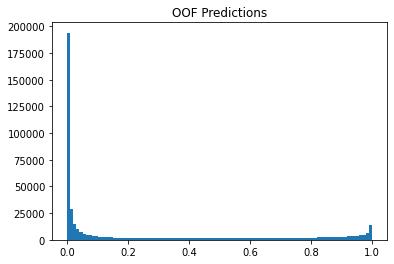

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

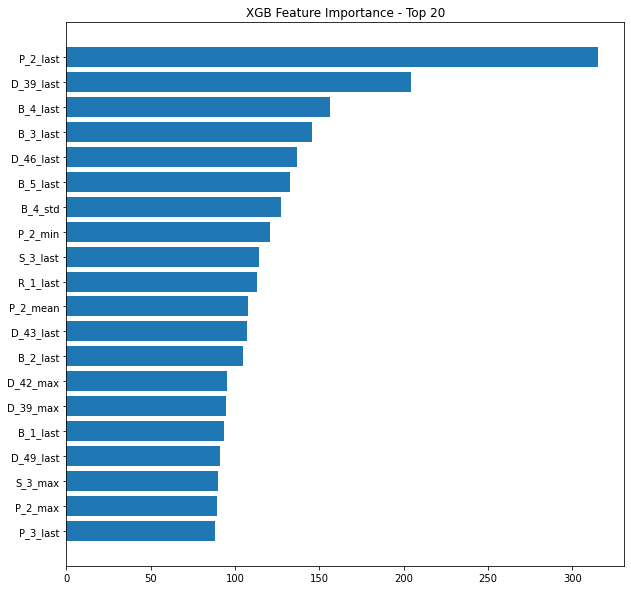

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data


In [ ]:
_ = gc.collect()

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = 'test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
test = handle_na(test,NAN_VALUE)
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
os.chdir('/content/drive/MyDrive/Amex/parquet/')

# Infer Test

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, growth)
    for m,k in col_added:
      test[f'{m}_{k}']= test[m]*test[k] 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del test 
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    #model.load_model('XGB_full.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{fold}.xgb')
        #model.load_model(f'XGB_full.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1114)


# Create Submission CSV

In [ ]:
# WRITE SUBMISSION FILE
#test_preds = np.concatenate(test_preds).to_numpy()
test = pd.DataFrame(index=customers,data={'prediction':[test_preds]})
sub = pd.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test['prediction'], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

TypeError: ignored

In [ ]:
sub.to_csv(f'/content/drive/My Drive/Amex/parquet/XGB Baseline/submission.csv',index=False)

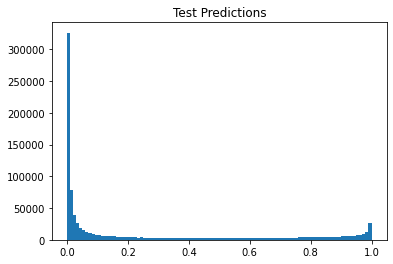

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()

Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=100,
                                                    stratify=y)